# Imports

## Imports

In [14]:
from IPython.display import display
import time

import datetime
import importlib
import re
import multiprocessing
import yaml
import os
import sys
import pickle
import collections

import scipy.stats
import random
import gzip
import os
import sys
import tempfile

from copy import deepcopy

import pandas as pd
import numpy as np
import itertools as itt

In [2]:
import sklearn_pandas
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.impute
from sklearn.externals import joblib

import imblearn

In [3]:
if not '/users/ldog/moyon/Thesis//scripts/' in sys.path:
    sys.path.insert(0,'/users/ldog/moyon/Thesis//scripts/')

import dataframes
importlib.reload(dataframes)

import ML_tests
importlib.reload(ML_tests)

import ML_visualization
importlib.reload(ML_visualization)

import ML_PCA
importlib.reload(ML_PCA)

<module 'ML_PCA' from '/users/ldog/moyon/Thesis/scripts/ML_PCA.py'>

In [4]:
if not '/users/ldog/moyon/Thesis/projects/FINSURF/createModels/' in sys.path:
    sys.path.insert(0,'/users/ldog/moyon/Thesis/projects/FINSURF/createModels/')

from select_variants import read_indices, write_indices, memory_aware_loading, load_model_dataset

from create_model_lib import find_best_threshold
from create_model_lib import export_kfolds_results
import create_model_lib

import finsurf_forest

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
husl = sns.color_palette('husl',32)
sns.palplot(husl)
plt.close()
plt.style.use('seaborn-notebook')

SMALL_SIZE=16
MEDIUM_SIZE=20
BIGGER_SIZE=22

mpl.rc('font',size=SMALL_SIZE)
mpl.rc('axes',titlesize=SMALL_SIZE)
mpl.rc('axes',labelsize=MEDIUM_SIZE)
mpl.rc('xtick',labelsize=SMALL_SIZE)
mpl.rc('ytick',labelsize=SMALL_SIZE)
mpl.rc('legend',fontsize=SMALL_SIZE)
mpl.rc('figure',titlesize=BIGGER_SIZE)

In [6]:
import pybedtools as pbt

tmp_dir = "/localtmp/moyon/"
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

tmp_dir = tempfile.TemporaryDirectory(dir=tmp_dir).name
os.makedirs(tmp_dir)
pbt.set_tempdir(tmp_dir)

print("Temporary BedTool files will be stored in '{}'".format(tmp_dir))

Temporary BedTool files will be stored in '/localtmp/moyon/tmpvxgifj6s'


## Definitions

In [7]:
chroms = ['chr{}'.format(i) for i in range(1,23)] + ['chrX','chrY']

In [8]:
# COLORS
colors_HGMD_contrib = ['#FF0000', # Red
                       '#f7f7f7', # white
                       '#053061' #Blue
                      ][::-1]

colors_enrichment = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8', # Violet
                     '#f7f7f7',
                     '#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b' # Green
                    ]



cmap_enrichment = mpl.colors.LinearSegmentedColormap.from_list('enrichment',
                                                               colors_enrichment,
                                                               N=51)

cmap_HGMD = mpl.colors.LinearSegmentedColormap.from_list('HGMD',
                                                               colors_HGMD_contrib,
                                                               N=51)

# The colors of datasets can be also used for the feature contributions.
dataset_colors = {
                'HGMD-DM':colors_HGMD_contrib[-1],  # Red
                'ClinVar_ctrl': colors_eQTL_contrib[0]  # Blue
                }

# Dataset

## Loading parameters


In [9]:
# BASE COLUMNS
hgmd_fp = "../../datasets/HGMD_variants/{}/Prefixed_4_VEP_HGMD_PRO_2017.2_hg19.tsv.gz"
hgmd_colmetadata_fp = "../../datasets/HGMD_variants/numeric/Prefixed_4_VEP_HGMD_PRO_2017.2_hg19_colMetadata.yaml"

hgmd_colmetadata = yaml.load(open(hgmd_colmetadata_fp,'r'))
original_cols = pd.read_table(hgmd_fp.format('numeric'),nrows=3).columns.values

col_types = {c:v['distype'] for c,v in hgmd_colmetadata.items() if not v['distype']=='other'}

feature_colors = {c:v['color'] for c,v in hgmd_colmetadata.items()}
feature_colors['vartrans.ord'] = '#30db88'

num_cols = [c for c in pd.read_table('../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model/datasets/X.tsv.gz',nrows=3).columns if c in col_types.keys()]

In [10]:
# ADDING THE GENES-ANNOTATIONS COLUMNS
if not 'ratio_shared_targets' in num_cols:
    num_cols.append('ratio_shared_targets')
    
if not 'targets_associations' in num_cols:
    num_cols.append('ratio_shared_targets')
    
# This will be used to update the metadata dict associated to the original numeric table.
targets_associations_metadata = {
    'ratio_shared_targets':{
        'category':'ENHANCERS',
        'color':'#1260e8',
        'distype':'continuous',
        'old_name':'ratio_shared_targets'
    },
    'targets_associations':{
        'category':'ENHANCERS',
        'color':'#1260e8',
        'distype':'discrete',
        'old_name':'targets_associations'
    }
}

hgmd_colmetadata.update(targets_associations_metadata)

# Regenerate the previous variables
col_types = {c:v['distype'] for c,v in hgmd_colmetadata.items() if not v['distype']=='other'}
feature_colors = {c:v['color'] for c,v in hgmd_colmetadata.items()}
feature_colors['vartrans.ord'] = '#30db88' # GENOME annotation ; by default my `annotToNum` script assigns it to "OTHER".
num_cols = [c for c in pd.read_table('../models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model/datasets/X.tsv.gz',nrows=3).columns if c in col_types.keys()]


col_cat = {c:v['category'] for c,v in hgmd_colmetadata.items() if not v['distype']=='other'}

cat_features = {}
# Maps names of categories to list of features
_ = {cat_features.setdefault(value,[]).append(key) for key, value in col_cat.items()}

# Here: correcting the category for vartrans
col_cat['vartrans.ord'] = 'GENOME'


# And finally produce the variables used for plots and training.
reduced_num_cols = [c for c in num_cols
                    if (not "mean" in c)
                        and (not "closest" in c)
                        and (not c.startswith('phyl46w'))
                        and (not c.startswith('phast46w'))
                   ]

## Loading datasets for training

There are two steps of selection :
- raw selection using the `select_variant` script ; this will apply a selection model (gencode Match, distance Match), retrieve variants according to it, filter the coding variants, and export the idx from the numeric table.
- fine selection in the "datasets_description" notebook : remove
    * negative variants overlapping positive variants
    * non-SNV variants (only for HGMD-DM, because no examples in the (+) set)
    * variants in blacklisted regions.

In [15]:
all_X_dfs = {'HGMD-DM':{},'eQTLs-OMIM':{}, 'eQTLs-ASD-OT':{}, 'eQTLs-ASD-SFARI':{}}
all_y_arrs = {'HGMD-DM':{},'eQTLs-OMIM':{}, 'eQTLs-ASD-OT':{}, 'eQTLs-ASD-SFARI':{}}
class_names = {'HGMD-DM':{},'eQTLs':{}}

### HGMD-DM

##### HGMD-DM - GENCODE

In [17]:
%%time
X, y = load_model_dataset("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model/datasets/")
y = np.array(y)

all_X_dfs['HGMD-DM']['gencodeMatch'] = X
all_y_arrs['HGMD-DM']['gencodeMatch'] = y
class_names['HGMD-DM']['gencodeMatch'] = ['ClinVar-ctrl','HGMD-DM']

print(("Original dataset contains {:,} samples, of which {:.3}% are positive samples.\n"
      ).format(all_X_dfs['HGMD-DM']['gencodeMatch'].shape[0], 100*all_y_arrs['HGMD-DM']['gencodeMatch'].sum()/len(all_y_arrs['HGMD-DM']['gencodeMatch'])))

Original dataset contains 220,183 samples, of which 0.399% are positive samples.

CPU times: user 4.92 s, sys: 4.22 s, total: 9.14 s
Wall time: 9.15 s


In [24]:
# THIS CODE IS FOR DOWNSAMPLING THE NUMBER OF VARIANTS.
# hgmd_gen_down_idx = pd.Series(all_y_arrs['HGMD-DM']['gencode']).sample(n=int((all_y_arrs['HGMD-DM']['gencode']==1).sum()*15), replace=False)
# # Remove the positives that were sampled.
# hgmd_gen_down_idx = hgmd_gen_down_idx.loc[(hgmd_gen_down_idx==0).values].index.values

# hgmd_gen_down_X = pd.concat([all_X_dfs['HGMD-DM']['gencode'].loc[(all_y_arrs['HGMD-DM']['gencode']==1),:],
#                              all_X_dfs['HGMD-DM']['gencode'].loc[hgmd_gen_down_idx,:]
#                             ],axis=0)

# hgmd_gen_down_y = all_y_arrs['HGMD-DM']['gencode'][hgmd_gen_down_X.index.values]
# hgmd_gen_down_X = hgmd_gen_down_X.reset_index(drop=True)

# all_X_dfs['HGMD-DM']['gencode_down'] = hgmd_gen_down_X
# all_y_arrs['HGMD-DM']['gencode_down'] = hgmd_gen_down_y

# print("Reduced from a dataset of {:,} samples ({:.3}% positives) to {:,} ({:.3}% positives)".format(all_X_dfs['HGMD-DM']['gencode'].shape[0], 100*all_y_arrs['HGMD-DM']['gencode'].sum()/len(all_y_arrs['HGMD-DM']['gencode']),
#                                                                                                     hgmd_gen_down_X.shape[0], 100*hgmd_gen_down_y.sum()/len(hgmd_gen_down_y)))

##### HGMD-DM - cytobands

In [17]:
%%time
X, y = load_model_dataset("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model//datasets/")
y = np.array(y)

all_X_dfs['HGMD-DM']['cytobandMatch'] = X
all_y_arrs['HGMD-DM']['cytobandMatch'] = y
class_names['HGMD-DM']['cytobandMatch'] = ['ClinVar-ctrl','HGMD-DM']

print("N_samples: {:,} ({:.3}% positives)\n".format(all_X_dfs['HGMD-DM']['cytobandMatch'].shape[0], 100*all_y_arrs['HGMD-DM']['cytobandMatch'].sum()/len(all_y_arrs['HGMD-DM']['cytobandMatch'])))

N_samples: 67,967 (1.29% positives)

CPU times: user 2.36 s, sys: 7.36 s, total: 9.72 s
Wall time: 9.77 s


In [ ]:
path_results_feat_contribs = '/users/ldog/moyon/Thesis/projects/FINSURF/figures/model_interpretation/new_HGMD-DM/feature_contributions/cytobandMatch/2020-05-11/'


##### HGMD-DM - Distance

In [16]:
%%time
X, y = load_model_dataset("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_distanceMatch/training_model/datasets/")
y = np.array(y)

all_X_dfs['HGMD-DM']['distanceMatch'] = X
all_y_arrs['HGMD-DM']['distanceMatch'] = y
class_names['HGMD-DM']['distanceMatch'] = ['ClinVar-ctrl','HGMD-DM']

print("N_samples: {:,} ({:.3}% positives)\n".format(all_X_dfs['HGMD-DM']['distanceMatch'].shape[0], 100*all_y_arrs['HGMD-DM']['distanceMatch'].sum()/len(all_y_arrs['HGMD-DM']['distanceMatch'])))

N_samples: 6,990 (12.5% positives)

CPU times: user 328 ms, sys: 2.37 s, total: 2.7 s
Wall time: 2.87 s


### HGMD-DM randomMatch

For this model I will need to load all ClinVar variants unfortunately ... 

Then I will need to apply filters on the rows to remove
- blacklist regions
- non-SNV (no INDEL in the HGMD)
- overlapping variants with HGMD)

In [18]:
if os.path.exists("/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model/datasets/X.tsv.gz"):
    print("FILE ALREADY EXISTS, NO NEED TO RUN THE CODE IN THE FOLLOWING SUBPARTS")
    X, y = load_model_dataset("/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model/datasets/")
    y = np.array(y)

    all_X_dfs['HGMD-DM']['noMatch'] = X
    all_y_arrs['HGMD-DM']['noMatch'] = y
    class_names['HGMD-DM']['noMatch'] = ['ClinVar-ctrl','HGMD-DM']

    print("N_samples: {:,} ({:.3}% positives)\n".format(all_X_dfs['HGMD-DM']['noMatch'].shape[0], 100*all_y_arrs['HGMD-DM']['noMatch'].sum()/len(all_y_arrs['HGMD-DM']['noMatch'])))

FILE ALREADY EXISTS, NO NEED TO RUN THE CODE IN THE FOLLOWING SUBPARTS


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


N_samples: 31,517,008 (0.00279% positives)



In [12]:
def verbose_read_table(path):
    print("Loading file : {}".format(os.path.basename(path)))
    table = pd.read_table(path)
    return table

In [13]:
coding_biotypes = ['start_codon','CDS','Selenocysteine','exon','stop_codon','splice_site']

#### HGMD-DM

In [15]:
hgmd_fp = "../../datasets/HGMD_variants/{}/Prefixed_4_VEP_HGMD_PRO_2017.2_hg19.tsv.gz"
hgmd_colmetadata_fp = "../../datasets/HGMD_variants/numeric/Prefixed_4_VEP_HGMD_PRO_2017.2_hg19_colMetadata.yaml"
hgmddm_gencode_indices_fp = "/users/ldog/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/HGMD-DM/Prefixed_4_VEP_HGMD_PRO_2017.2_hg19.txt"

tmp = pd.read_table('/kingdoms/dyogen/workspace5/RegulationData/hg19/variants/2018BRIDGE_HGMD/raw/HGMD_VCF_indexes_noCDS_noProtImpact_DM.tsv')
hgmddm_noCDS_noProtImpact_rowids = 'chr'+tmp['chrom'].astype('str')+'_'+tmp['row_id'].astype('str')


hgmd_df_full = pd.read_csv(hgmd_fp.format('numeric'),sep="\t")
hgmd_df_full_iscoding = hgmd_df_full['biotypes.best_biotype'].replace(np.nan,'biotype:intergenic'
                         ).apply(lambda v: dataframes.get_field_kv_pairs_list(v,',',':','biotype')).isin(coding_biotypes)


# Now get the df of hgmddm_nc variants.
hgmddm_df = hgmd_df_full.loc[(hgmd_df_full['row_id'].isin(hgmddm_noCDS_noProtImpact_rowids)) &\
                 ~hgmd_df_full_iscoding,
                 :
                ].copy()

#### ClinVar

In [16]:
# Loading the numeric dataframes
clinvar_fp = "/kingdoms/dyogen/workspace5/RegulationData/hg19/variants/clinvar_noImpact/numeric/{chrom}.tsv.gz"


all_clinvar_files = collections.OrderedDict([
                        (chrom,clinvar_fp.format(chrom=chrom))
                        for chrom in chroms
                        if os.path.isfile(clinvar_fp.format(chrom=chrom))
])

# GENES ANNOTATIONS - NC HGMDDM GENES
clinvar_fp_genes_hgmd = "/users/ldog/moyon/Thesis/projects/FINSURF/models/new_ClinVar_HGMDDM_genes/{chrom}_GENES.tsv.gz"

all_clinvar_files_GENES = collections.OrderedDict([
                        (chrom,clinvar_fp.format(chrom=chrom))
                        for chrom in chroms
                        if os.path.isfile(clinvar_fp.format(chrom=chrom))
])

In [21]:
print("Loading numeric tables")

clinvar_df_perchrom = {}
for chrom in chroms:
    if os.path.isfile(clinvar_fp.format(chrom=chrom)):
        clinvar_df_perchrom[chrom] = verbose_read_table(clinvar_fp.format(chrom=chrom))
        

print("Loading GENES tables")

for chrom in chroms:
    if os.path.isfile(clinvar_fp_genes_hgmd.format(chrom=chrom)):
        print("Loading file : {}".format(chrom))
        table = pd.read_table(clinvar_fp_genes_hgmd.format(chrom=chrom),usecols=['ratio_shared_targets','targets_associations'])
        clinvar_df_perchrom[chrom] = pd.concat([clinvar_df_perchrom[chrom], table],axis=1)

Loading numeric tables
Loading file : chr1.tsv.gz


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Loading file : chr2.tsv.gz
Loading file : chr3.tsv.gz
Loading file : chr4.tsv.gz
Loading file : chr5.tsv.gz
Loading file : chr6.tsv.gz
Loading file : chr7.tsv.gz
Loading file : chr8.tsv.gz
Loading file : chr9.tsv.gz
Loading file : chr10.tsv.gz
Loading file : chr11.tsv.gz
Loading file : chr12.tsv.gz
Loading file : chr13.tsv.gz
Loading file : chr14.tsv.gz
Loading file : chr15.tsv.gz
Loading file : chr16.tsv.gz
Loading file : chr17.tsv.gz
Loading file : chr18.tsv.gz
Loading file : chr19.tsv.gz
Loading file : chr20.tsv.gz
Loading file : chr21.tsv.gz
Loading file : chr22.tsv.gz
Loading file : chrX.tsv.gz
Loading file : chrY.tsv.gz
Loading GENES tables
Loading file : chr1
Loading file : chr2
Loading file : chr3
Loading file : chr4
Loading file : chr5
Loading file : chr6
Loading file : chr7
Loading file : chr8
Loading file : chr9
Loading file : chr10
Loading file : chr11
Loading file : chr12
Loading file : chr13
Loading file : chr14
Loading file : chr15
Loading file : chr16
Loading file : chr

In [22]:
def get_indices_todrop_clinvar_RANDOMMODEL(chrom):
    print(chrom)
    biotypes = clinvar_df_perchrom[chrom]['biotypes.best_biotype'].replace(np.nan,'biotype:intergenic').apply(lambda v: dataframes.get_field_kv_pairs_list(v,',',':','biotype'))
    is_coding = biotypes.isin(coding_biotypes)
    clinvar_indices_todrop = clinvar_df_perchrom[chrom].loc[(~clinvar_df_perchrom[chrom]['blacklist'].isnull()) & is_coding,:].index.values
    clinvar_indices_todrop = list(clinvar_indices_todrop)
    
    # Removing INDELs
    removed_indices_indels = clinvar_df_perchrom[chrom].loc[clinvar_df_perchrom[chrom]['vartype']!='SNV',:].index.values
    clinvar_indices_todrop += list(removed_indices_indels)
           
    # Removing also the variants overlapping HGMD-DM
    HGMD_POS = ['chrom_'+str(v) for v in hgmddm_df.loc[hgmddm_df['chrom']==chrom,'start'].values]
    
    
    # Note : here, ugly removal based on the positions of the variants.
    removed_indices_olpos = clinvar_df_perchrom[chrom].loc[(clinvar_df_perchrom[chrom]['chrom']+'_'+clinvar_df_perchrom[chrom]['start'].astype(str)
                                                            ).isin(HGMD_POS),:].index.values
    
    clinvar_indices_todrop += list(removed_indices_olpos)
    
    return clinvar_indices_todrop


pool = multiprocessing.Pool(12)
clinvar_indices_todrop_perchrom = pool.map(get_indices_todrop_clinvar_RANDOMMODEL, clinvar_df_perchrom.keys())
pool.close()
pool.join()

clinvar_indices_todrop_perchrom = dict(zip(clinvar_df_perchrom.keys(), clinvar_indices_todrop_perchrom))

chr1
chr3
chr4
chr5
chr6
chr7
chr8
chr2
chr9
chr11
chr12
chr10
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
chrX
chrY


#### FULL X

In [45]:
%%time
X_HGMDDM_random = [hgmddm_df.copy()]

for chrom in chroms:
    print(chrom)
    tmp = clinvar_df_perchrom[chrom]
    kept_idx = sorted(list(set(tmp.index.values) - set(clinvar_indices_todrop_perchrom[chrom])))
    X_HGMDDM_random.append(tmp.loc[kept_idx,:])
    
X_HGMDDM_random = pd.concat(X_HGMDDM_random)
y_HGMDDM_random = np.array([1 for _ in range(hgmddm_df.shape[0])] +\
                           [0 for _ in range(X_HGMDDM_random.shape[0]-hgmddm_df.shape[0])]
                          )

assert X_HGMDDM_random.shape[0] == y_HGMDDM_random.shape[0], 'ERROR: not same number of samples in X and y'

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
chrX
chrY


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [105]:
from select_variants import memory_aware_loading, read_indices, write_indices, load_model_dataset, export_dataset_model

In [107]:
class_names = ('ClinVar', 'HGMD-DM') # Needs to be ordered
split_by_chrom = (True, False)

outputdir_model = "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model/"


export_dataset_model(X_HGMDDM_random, y_HGMDDM_random, class_names, split_by_chrom, outputdir_model)

	Created file: '/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model//datasets//datasets/ClinVar_numeric_df_indices//chr1_indices.txt'
	Created file: '/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model//datasets//datasets/ClinVar_numeric_df_indices//chr2_indices.txt'
	Created file: '/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model//datasets//datasets/ClinVar_numeric_df_indices//chr3_indices.txt'
	Created file: '/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model//datasets//datasets/ClinVar_numeric_df_indices//chr4_indices.txt'
	Created file: '/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model//datasets//datasets/ClinVar_numeric_df_indices

# Models

## Pipeline

The pipeline should be as follow:
- replace NaN locally (ie when cross-validating, do not infer NaN on the full dataset, but only on the N-k folds used for training (avoids data leakage)
- fit the random forests

* Conservation annotations should be associated to a "local inference of NaNs through the median". Indeed the mean value of the entire genome is not 0 ; also it is safe to assume that given a dataset for training, this dataset might have been biased on purpose (e.g.: HGMD-DM vs ClinVar_ctrl distance-matched should be biased for promoter-proximal variants => unlikely to have a null conservation). Except for GERP Element.

* CGdinit : either 0 or 1 ; we should bias for the most-represented value in the dataset, although since it's sequence-based there should be no NaN value.
* CpGisland: either 0 or 1 ; same.
* histone median signals : those are summary values from different datasets. NaNs should be replaced by the median value (same reasoning as Conservation).
* TFBS : derived from the presence / absence of TF binding events. If NaN : safe to assume that there was no signal.
* enhancers : same.
* DNAse signal : same.
* Roadmap : the columns here are non-independant. There should be no NaN situation, as during the annotation the missing states for one position were assigned a 0. So fill with 0 for any NaN.

In [87]:
try:
    mapper = create_model_lib.build_mapper_features_preprocessing(cat_features, X, reduced_num_cols, cols_to_drop=['linsight','targets_associations'])
except NameError:
    try:
        mapper = create_model_lib.build_mapper_features_preprocessing(cat_features, 
                                                     clinvar_df_perchrom['chr19'],
                                                     reduced_num_cols,
                                                     cols_to_drop=['linsight','targets_associations']
                                                    )
    except Exception as e:
        raise e

Columns without assigned Impute strategy (will be lost if no strategy set):


['linsight', 'targets_associations']

In [88]:
rdf = finsurf_forest.RandomForestClassifier(n_estimators=100,
                                            max_depth=8,
                                            min_samples_leaf=5,
                                            max_features='sqrt',
                                            n_jobs=12)


pipeline = sklearn.pipeline.Pipeline([
            ('preprocessing', mapper),
            ('balanced_rdf', rdf)
            ])

## Training

In [89]:
# THIS IS OUR FINALE SELECTED MODEL.

# Two sets of columns and associated pipelines are created : one with the information of the disease-target genes associations, and one without.
red_cols1 = [c for c in reduced_num_cols if c not in ['linsight']]
red_cols2 = [c for c in reduced_num_cols if c not in ['linsight','targets_associations']]
mapper1 = build_mapper_features_preprocessing(cat_features, X, red_cols1)
mapper2 = build_mapper_features_preprocessing(cat_features, X, red_cols2)


rdf = finsurf_forest.RandomForestClassifier(n_estimators=1000,
                                            max_depth=15,
                                            min_samples_leaf=1,
                                            max_features='sqrt',
                                            n_jobs=24)


# This pipeline will include the "targets_associations" column
pipeline1 = sklearn.pipeline.Pipeline([
            ('preprocessing', mapper1),
            ('balanced_rdf', rdf)
            ])

# This pipeline will be less biased, as it does not contain the "targets_associations" column.
pipeline2 = sklearn.pipeline.Pipeline([
            ('preprocessing', mapper2),
            ('balanced_rdf', rdf)
            ])

Columns without assigned Impute strategy (will be lost if no strategy set):


[]

Columns without assigned Impute strategy (will be lost if no strategy set):


[]

### HGMD-DM RANDOM MATCH

In [23]:
path_model = "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/"
if not os.path.exists(path_model):
    os.makedirs(path_model)

#### cytoband-aware cross-validation

In [54]:
tmp_X = X_HGMDDM_random.assign(cytoband=lambda df: df['chrom']+df['cytoband']).reset_index(drop=True)
tmp_y = pd.Series(y_HGMDDM_random)

In [51]:
import imblearn
importlib.reload(create_model_lib)

<module 'create_model_lib' from '/users/ldog/moyon/Thesis/projects/FINSURF/createModels/create_model_lib.py'>

In [55]:
%%time
clf = sklearn.base.clone(pipeline2, safe=True)


random_model_all_res_kfolds_wotargs_cytobased = create_model_lib.categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols2,
                                                    category='cytoband',
                                                    K=10,
                                                    get_proba=True,
                                                    test_imb_ratio=0.125
                                                    )

2019-10-23 17:31:52 - split 1 : train size : 28,291,283 ((+)=0.00297%) | test size : 360 ((+)=11.1%)
	2019-10-23 18:02:36 - Test evaluation.
2019-10-23 18:04:31 - split 2 : train size : 28,547,416 ((+)=0.00219%) | test size : 2,304 ((+)=11.1%)
	2019-10-23 18:24:54 - Test evaluation.
2019-10-23 18:26:51 - split 3 : train size : 28,337,798 ((+)=0.0029%) | test size : 522 ((+)=11.1%)
	2019-10-23 18:46:52 - Test evaluation.
2019-10-23 18:48:47 - split 4 : train size : 28,321,858 ((+)=0.00295%) | test size : 396 ((+)=11.1%)
	2019-10-23 19:08:52 - Test evaluation.
2019-10-23 19:10:47 - split 5 : train size : 28,628,206 ((+)=0.00279%) | test size : 720 ((+)=11.1%)
	2019-10-23 19:31:15 - Test evaluation.
2019-10-23 19:33:13 - split 6 : train size : 28,387,594 ((+)=0.00289%) | test size : 540 ((+)=11.1%)
	2019-10-23 19:53:20 - Test evaluation.
2019-10-23 19:55:26 - split 7 : train size : 28,181,657 ((+)=0.00288%) | test size : 603 ((+)=11.1%)
	2019-10-23 20:15:22 - Test evaluation.
2019-10-23 2

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


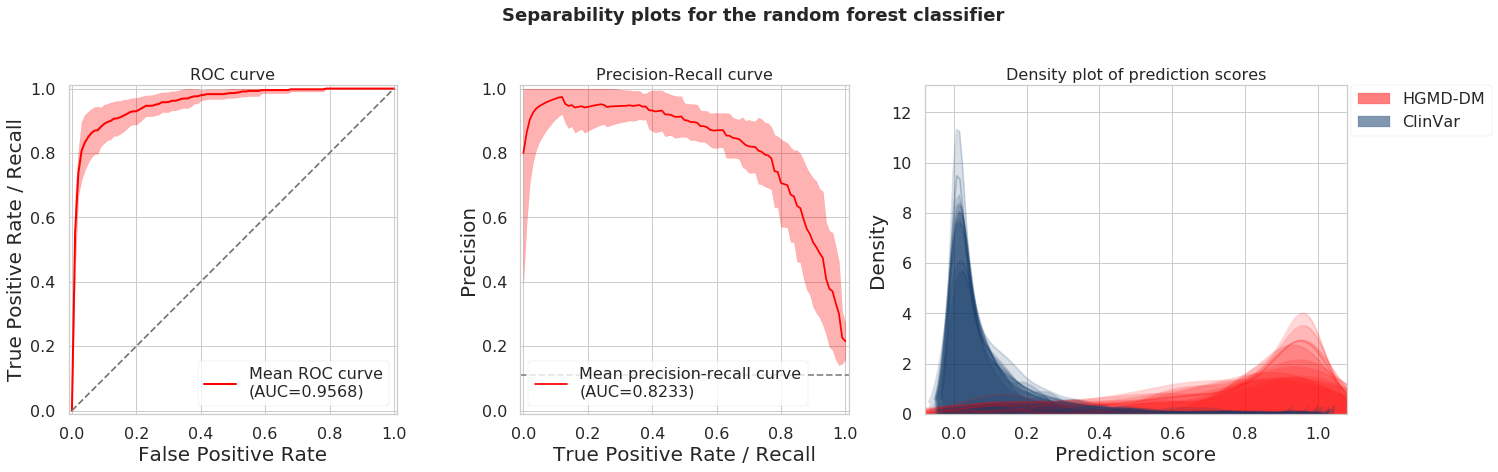

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


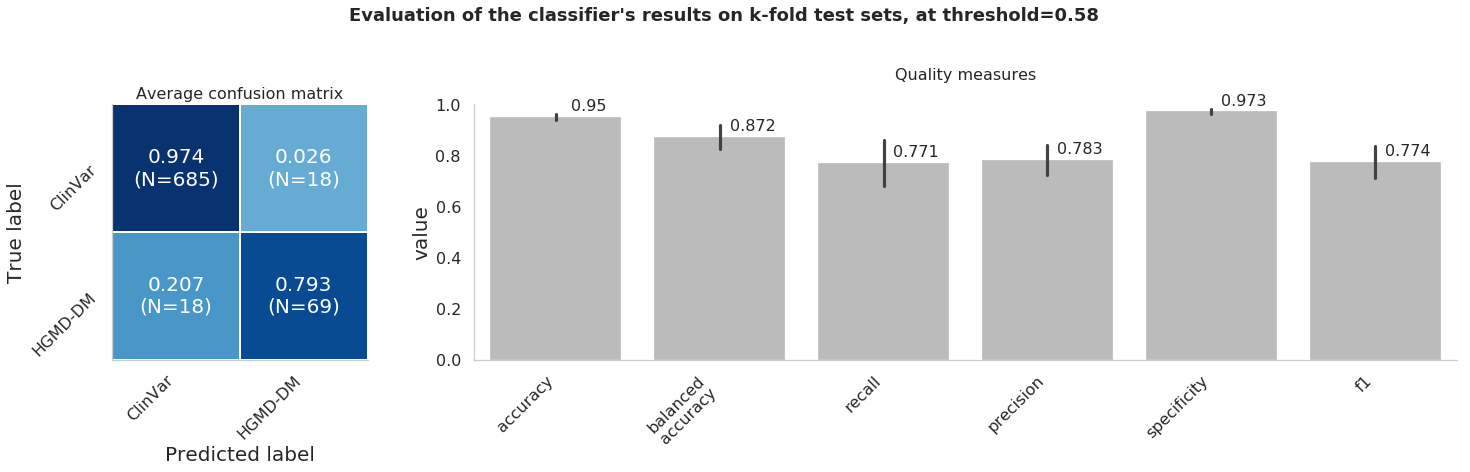

CPU times: user 1.12 s, sys: 16 ms, total: 1.14 s
Wall time: 1.23 s


In [56]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    random_model_all_res_kfolds_wotargs_cytobased,
                    mean_only=True,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier',
                    #savefig_file="/users/ldog/moyon/Thesis/HGMD-DM_RANDOM_separability_curves.svg"
                    )

# FIGURE ON QUALITY OF PREDICTIONS
threshold = create_model_lib.find_best_threshold([v[0] for v in random_model_all_res_kfolds_wotargs_cytobased],
                                [v[1] for v in random_model_all_res_kfolds_wotargs_cytobased],
                                scorer=sklearn.metrics.f1_score
                               )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in random_model_all_res_kfolds_wotargs_cytobased],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in random_model_all_res_kfolds_wotargs_cytobased],
                             normalize=True,
                             class_names=['ClinVar','HGMD-DM'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
                             #savefig_file="/users/ldog/moyon/Thesis/writting/FINSURF_ARTICLE/00_pre-submission/02_figures/figure_evaluating_classifiers/panel_HGMD-DM_GENCODE_quality-measures_F1-optim.svg"
)

In [58]:
random_model_all_res_kfolds_wotargs_cytobased = copy.deepcopy(all_res_kfolds_wotargs_cytobased)

In [108]:
export_kfolds_results(random_model_all_res_kfolds_wotargs_cytobased, path_model+'/CytobandAware10Folds_woTargs/')

Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch//CytobandAware10Folds_woTargs//kfold_00//y_test.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch//CytobandAware10Folds_woTargs//kfold_00//y_pred.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch//CytobandAware10Folds_woTargs//kfold_00//test_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch//CytobandAware10Folds_woTargs//kfold_00//train_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch//CytobandAware10Folds_woTargs//kfold_00//model.pkl"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch//

#### Full Models

Note : this model won't really be used after. The comparative performance of models on cross-datasets is done through the k-folds, so in the end the only important element is the k-fold results.

In [ ]:
# Train full model and export.
finale_model = sklearn.base.clone(pipeline1, safe=True)
finale_model.fit(all_X_dfs['HGMD-DM']['distanceMatch'].loc[:,red_cols1],
                 all_y_arrs['HGMD-DM']['distanceMatch'])

# No need to export the sample indexes : one just need to load the X dataframes, the model, and use the get_sample_idx functions from each tree.
joblib.dump(finale_model, path_model+'/full-model_wTargs.pkl', compress=9)

with open(path_model+'/full-model_wTargs_columns.txt','w') as pf:
    for c in red_cols1:
        pf.write(c)
        pf.write('\n')

In [ ]:
# Train full model and export.
finale_model = sklearn.base.clone(pipeline2, safe=True)
finale_model.fit(X_HGMDDM_random.loc[:,red_cols2],
                 pd.Series(y_))

# No need to export the sample indexes : one just need to load the X dataframes, the model, and use the get_sample_idx functions from each tree.
joblib.dump(finale_model, path_model+'/full-model_woTargs.pkl', compress=9)

with open(path_model+'/full-model_woTargs_columns.txt','w') as pf:
    for c in red_cols2:
        pf.write(c)
        pf.write('\n')

### HGMD-DM - GENCODE

In [23]:
path_model = "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model/"

#### Simple k-fold

The stratified K-fold method splits the dataset into K-folds while preserving the class representations in each fold ; the K-folds are composed of elements sampled independantly (ie one position cannot be found in multiple k-folds). Note that this does not preserve from situations where multiple positions are very close / neighbours, which might favorise the quality of the classifier.

In [612]:
splitter = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [641]:
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs = ML_tests.stratifiedkfold_predict(
                                            clf,
                                            all_X_dfs['HGMD-DM']['gencodeMatch'].loc[:,red_cols1],
                                            pd.Series(all_y_arrs['HGMD-DM']['gencodeMatch']),
                                            features=red_cols1,
                                            splitter=splitter,
                                            get_proba=True,
                                            test_imb_ratio=0.126
                                            )

2019-05-29 12:01:37 - split 1 : train size: 1,602,882 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:04:12 - Test evaluation.


2019-05-29 12:04:14 - split 2 : train size: 1,602,882 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:06:51 - Test evaluation.


2019-05-29 12:06:54 - split 3 : train size: 1,602,882 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:09:28 - Test evaluation.


2019-05-29 12:09:29 - split 4 : train size: 1,602,883 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:12:06 - Test evaluation.


2019-05-29 12:12:07 - split 5 : train size: 1,602,883 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:14:42 - Test evaluation.


2019-05-29 12:14:43 - split 6 : train size: 1,602,883 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:17:21 - Test evaluation.


2019-05-29 12:17:23 - split 7 : train size: 1,602,883 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:20:02 - Test evaluation.


2019-05-29 12:20:07 - split

In [642]:
clf = sklearn.base.clone(pipeline2, safe=True)

all_res_kfolds_wotargs = ML_tests.stratifiedkfold_predict(
                                            clf,
                                            all_X_dfs['HGMD-DM']['gencodeMatch'].loc[:,red_cols2],
                                            pd.Series(all_y_arrs['HGMD-DM']['gencodeMatch']),
                                            features=red_cols2,
                                            splitter=splitter,
                                            get_proba=True,
                                            test_imb_ratio=0.126
                                            )

2019-05-29 12:28:03 - split 1 : train size: 1,602,882 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:30:43 - Test evaluation.


2019-05-29 12:30:44 - split 2 : train size: 1,602,882 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:33:23 - Test evaluation.


2019-05-29 12:33:25 - split 3 : train size: 1,602,882 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:36:01 - Test evaluation.


2019-05-29 12:36:03 - split 4 : train size: 1,602,883 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:38:40 - Test evaluation.


2019-05-29 12:38:42 - split 5 : train size: 1,602,883 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:41:18 - Test evaluation.


2019-05-29 12:41:20 - split 6 : train size: 1,602,883 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:43:57 - Test evaluation.


2019-05-29 12:43:59 - split 7 : train size: 1,602,883 ((+)=0.0493%) ; test size: 786 ((+)=11.2%)
	2019-05-29 12:46:36 - Test evaluation.


2019-05-29 12:46:38 - split

In [645]:
export_kfolds_results(all_res_kfolds_wtargs, path_model+'/Stratified10Folds_wTargs/')
export_kfolds_results(all_res_kfolds_wotargs, path_model+'/Stratified10Folds_woTargs/')

Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//Stratified10Folds_wTargs//kfold_00//y_test.tx"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//Stratified10Folds_wTargs//kfold_00//y_pred.tx"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//Stratified10Folds_wTargs//kfold_00//test_index.tx"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//Stratified10Folds_wTargs//kfold_00//train_index.tx"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//Stratified10Folds_wTargs//kfold_00//model.pkl"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_genco

/users/ldog/moyon/anaconda3/envs/dnm_env/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


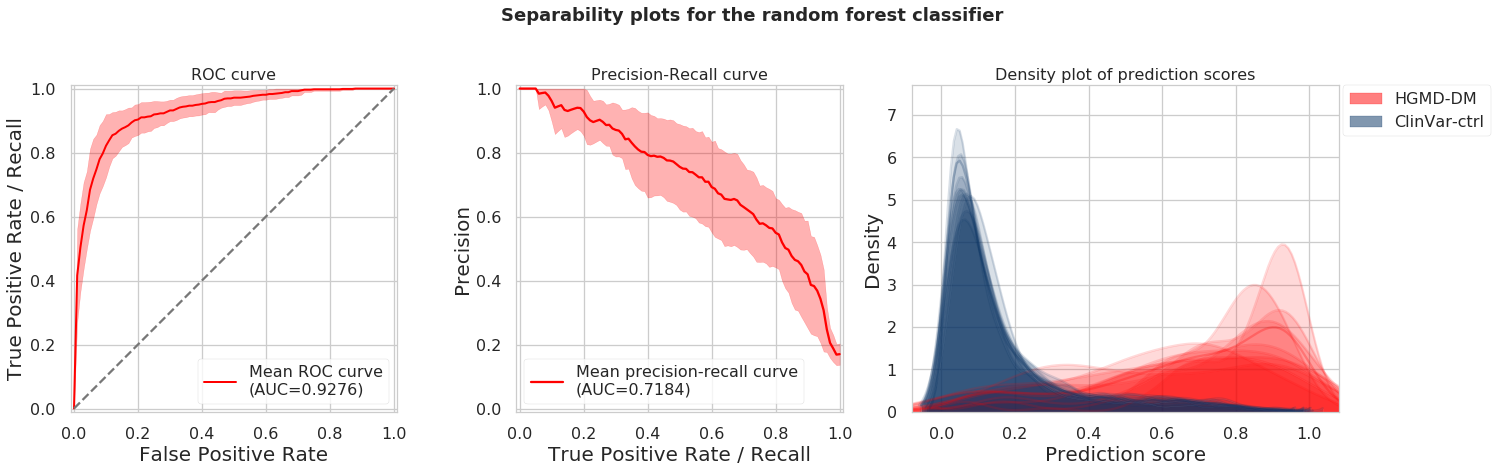

/users/ldog/moyon/anaconda3/envs/dnm_env/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


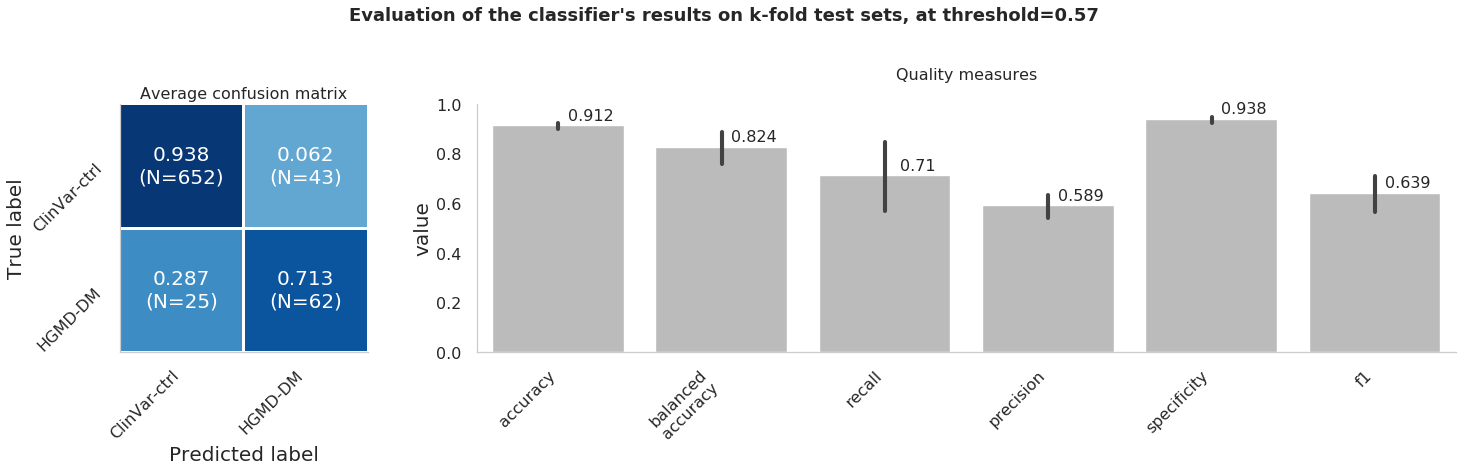

CPU times: user 1.37 s, sys: 68 ms, total: 1.44 s
Wall time: 1.47 s


In [610]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    all_res_kfolds['hgmddm_gencode_wotargs'],
                    mean_only=True,
                    class_names = class_names['HGMD-DM']['gencodeMatch'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier',
                    #savefig_file="/users/ldog/moyon/Thesis/writting/FINSURF_ARTICLE/00_pre-submission/02_figures/figure_evaluating_classifiers/panel_HGMD-DM_GENCODE_separability_curves.svg"
                    )

# FIGURE ON QUALITY OF PREDICTIONS
threshold = find_best_threshold([v[0] for v in all_res_kfolds['hgmddm_gencode_wotargs']],
                                [v[1] for v in all_res_kfolds['hgmddm_gencode_wotargs']],
                                scorer=sklearn.metrics.f1_score
                               )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in all_res_kfolds['hgmddm_gencode_wotargs']],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in all_res_kfolds['hgmddm_gencode_wotargs']],
                             normalize=True,
                             class_names=class_names['HGMD-DM']['gencodeMatch'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
                             #savefig_file="/users/ldog/moyon/Thesis/writting/FINSURF_ARTICLE/00_pre-submission/02_figures/figure_evaluating_classifiers/panel_HGMD-DM_GENCODE_quality-measures_F1-optim.svg"
)

#### Cytoband-aware cross-validation

In [652]:
tmp_X = all_X_dfs['HGMD-DM']['gencodeMatch'].assign(cytoband=lambda df: df['chrom']+df['cytoband'])
tmp_y = pd.Series(all_y_arrs['HGMD-DM']['gencodeMatch'])

In [653]:
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols1,
                                                    category='cytoband',
                                                    K=10,
                                                    get_proba=True,
                                                    test_imb_ratio=0.126
                                                    )

2019-05-29 17:00:30 - split 1 : train size : 1,610,618 ((+)=0.0514%)test size : 446 ((+)=11.2%)
	2019-05-29 17:03:10 - Test evaluation.
2019-05-29 17:03:17 - split 2 : train size : 1,603,340 ((+)=0.0505%)test size : 607 ((+)=11.2%)
	2019-05-29 17:05:55 - Test evaluation.
2019-05-29 17:06:01 - split 3 : train size : 1,608,807 ((+)=0.0464%)test size : 1,179 ((+)=11.2%)
	2019-05-29 17:08:41 - Test evaluation.
2019-05-29 17:08:47 - split 4 : train size : 1,598,452 ((+)=0.045%)test size : 1,420 ((+)=11.2%)
	2019-05-29 17:11:24 - Test evaluation.
2019-05-29 17:11:31 - split 5 : train size : 1,611,549 ((+)=0.0506%)test size : 554 ((+)=11.2%)
	2019-05-29 17:14:09 - Test evaluation.
2019-05-29 17:14:16 - split 6 : train size : 1,588,928 ((+)=0.0484%)test size : 974 ((+)=11.2%)
	2019-05-29 17:16:52 - Test evaluation.
2019-05-29 17:16:59 - split 7 : train size : 1,594,951 ((+)=0.0517%)test size : 482 ((+)=11.2%)
	2019-05-29 17:19:38 - Test evaluation.
2019-05-29 17:19:44 - split 8 : train size : 

In [654]:
%%time
clf = sklearn.base.clone(pipeline2, safe=True)


all_res_kfolds_wotargs = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols2,
                                                    category='cytoband',
                                                    K=10,
                                                    get_proba=True,
                                                    test_imb_ratio=0.126
                                                    )

2019-05-29 17:28:02 - split 1 : train size : 1,617,401 ((+)=0.049%)test size : 768 ((+)=11.2%)
	2019-05-29 17:30:43 - Test evaluation.
2019-05-29 17:30:50 - split 2 : train size : 1,607,468 ((+)=0.0498%)test size : 697 ((+)=11.2%)
	2019-05-29 17:33:30 - Test evaluation.
2019-05-29 17:33:36 - split 3 : train size : 1,599,099 ((+)=0.0455%)test size : 1,340 ((+)=11.2%)
	2019-05-29 17:36:15 - Test evaluation.
2019-05-29 17:36:21 - split 4 : train size : 1,592,563 ((+)=0.0491%)test size : 857 ((+)=11.2%)
	2019-05-29 17:39:00 - Test evaluation.
2019-05-29 17:39:06 - split 5 : train size : 1,610,936 ((+)=0.0489%)test size : 804 ((+)=11.2%)
	2019-05-29 17:44:20 - Test evaluation.
2019-05-29 17:44:59 - split 6 : train size : 1,604,746 ((+)=0.0522%)test size : 357 ((+)=11.2%)
	2019-05-29 17:48:53 - Test evaluation.
2019-05-29 17:48:59 - split 7 : train size : 1,629,124 ((+)=0.0501%)test size : 554 ((+)=11.2%)
	2019-05-29 17:52:10 - Test evaluation.
2019-05-29 17:52:17 - split 8 : train size : 1,

In [670]:
create_model_lib.export_kfolds_results(all_res_kfolds_wtargs, path_model+'/CytobandAware10Folds_wTargs/')
create_model_lib.export_kfolds_results(all_res_kfolds_wotargs, path_model+'/CytobandAware10Folds_woTargs/')

Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_wTargs//kfold_00//y_test.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_wTargs//kfold_00//y_pred.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_wTargs//kfold_00//test_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_wTargs//kfold_00//train_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_wTargs//kfold_00//model.pkl"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_

Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//y_test.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//y_pred.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//test_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//train_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//model.pkl"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGM

#### Full models

In [648]:
# Train full model and export.
finale_model = sklearn.base.clone(pipeline1, safe=True)
finale_model.fit(all_X_dfs['HGMD-DM']['gencodeMatch'].loc[:,red_cols1],
                 all_y_arrs['HGMD-DM']['gencodeMatch'])

# No need to export the sample indexes : one just need to load the X dataframes, the model, and use the get_sample_idx functions from each tree.
joblib.dump(finale_model, path_model+'/full-model_wTargs.pkl', compress=9)

with open(path_model+'/full-model_wTargs_columns.txt','w') as pf:
    for c in red_cols1:
        pf.write(c)
        pf.write('\n')

In [649]:
# Train full model and export.
finale_model = sklearn.base.clone(pipeline2, safe=True)
finale_model.fit(all_X_dfs['HGMD-DM']['gencodeMatch'].loc[:,red_cols2],
                 all_y_arrs['HGMD-DM']['gencodeMatch'])

# No need to export the sample indexes : one just need to load the X dataframes, the model, and use the get_sample_idx functions from each tree.
joblib.dump(finale_model, path_model+'/full-model_woTargs.pkl', compress=9)

with open(path_model+'/full-model_woTargs_columns.txt','w') as pf:
    for c in red_cols2:
        pf.write(c)
        pf.write('\n')

### HGMD-DM - CYTOBAND

In [60]:
path_model = "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/"

#### Simple k-fold

In [130]:
splitter = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [131]:
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs_testImb = ML_tests.stratifiedkfold_predict(
                                            clf,
                                            all_X_dfs['HGMD-DM']['cytobandMatch'].loc[:,red_cols1],
                                            pd.Series(all_y_arrs['HGMD-DM']['cytobandMatch']),
                                            features=red_cols1,
                                            splitter=splitter,
                                            get_proba=True,
                                            test_imb_ratio=0.125
                                            )

export_kfolds_results(all_res_kfolds_wtargs_testImb, path_model+'/Stratified10Folds_wTargs_testImb12.5/')

2019-09-04 14:37:32 - split 1 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:37:35 - Test evaluation.


2019-09-04 14:37:35 - split 2 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:37:38 - Test evaluation.


2019-09-04 14:37:38 - split 3 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:37:42 - Test evaluation.


2019-09-04 14:37:42 - split 4 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:37:45 - Test evaluation.


2019-09-04 14:37:45 - split 5 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:37:49 - Test evaluation.


2019-09-04 14:37:49 - split 6 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:37:52 - Test evaluation.


2019-09-04 14:37:53 - split 7 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:37:56 - Test evaluation.


2019-09-04 14:37:56 - split 8 : train size: 61,170 ((+)=1.29%)

In [132]:
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs_notestImb = ML_tests.stratifiedkfold_predict(
                                            clf,
                                            all_X_dfs['HGMD-DM']['cytobandMatch'].loc[:,red_cols1],
                                            pd.Series(all_y_arrs['HGMD-DM']['cytobandMatch']),
                                            features=red_cols1,
                                            splitter=splitter,
                                            get_proba=True,
                                            #test_imb_ratio=0.125
                                            )

export_kfolds_results(all_res_kfolds_wtargs_notestImb, path_model+'/Stratified10Folds_wTargs_notestImb/')

2019-09-04 14:39:53 - split 1 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:39:56 - Test evaluation.


2019-09-04 14:39:56 - split 2 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:39:59 - Test evaluation.


2019-09-04 14:40:00 - split 3 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:40:03 - Test evaluation.


2019-09-04 14:40:04 - split 4 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:40:07 - Test evaluation.


2019-09-04 14:40:08 - split 5 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:40:11 - Test evaluation.


2019-09-04 14:40:11 - split 6 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:40:15 - Test evaluation.


2019-09-04 14:40:15 - split 7 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:40:18 - Test evaluation.


2019-09-04 14:40:19 - split 8 : train size: 61,1

In [133]:
clf = sklearn.base.clone(pipeline2, safe=True)

all_res_kfolds_wotargs_testImb = ML_tests.stratifiedkfold_predict(
                                            clf,
                                            all_X_dfs['HGMD-DM']['cytobandMatch'].loc[:,red_cols2],
                                            pd.Series(all_y_arrs['HGMD-DM']['cytobandMatch']),
                                            features=red_cols2,
                                            splitter=splitter,
                                            get_proba=True,
                                            test_imb_ratio=0.125
                                            )


export_kfolds_results(all_res_kfolds_wotargs_testImb, path_model+'/Stratified10Folds_woTargs_testImb12.5/')

2019-09-04 14:42:17 - split 1 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:42:20 - Test evaluation.


2019-09-04 14:42:21 - split 2 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:42:24 - Test evaluation.


2019-09-04 14:42:24 - split 3 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:42:28 - Test evaluation.


2019-09-04 14:42:28 - split 4 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:42:31 - Test evaluation.


2019-09-04 14:42:31 - split 5 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:42:34 - Test evaluation.


2019-09-04 14:42:35 - split 6 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:42:38 - Test evaluation.


2019-09-04 14:42:38 - split 7 : train size: 61,170 ((+)=1.29%) ; test size: 792 ((+)=11.1%)
	2019-09-04 14:42:42 - Test evaluation.


2019-09-04 14:42:42 - split 8 : train size: 61,170 ((+)=1.29%)

In [134]:
clf = sklearn.base.clone(pipeline2, safe=True)

all_res_kfolds_wotargs_notestImb = ML_tests.stratifiedkfold_predict(
                                            clf,
                                            all_X_dfs['HGMD-DM']['cytobandMatch'].loc[:,red_cols2],
                                            pd.Series(all_y_arrs['HGMD-DM']['cytobandMatch']),
                                            features=red_cols2,
                                            splitter=splitter,
                                            get_proba=True,
                                            #test_imb_ratio=0.125
                                            )


export_kfolds_results(all_res_kfolds_wotargs_notestImb, path_model+'/Stratified10Folds_woTargs_notestImb/')

2019-09-04 14:45:28 - split 1 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:45:32 - Test evaluation.


2019-09-04 14:45:32 - split 2 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:45:35 - Test evaluation.


2019-09-04 14:45:36 - split 3 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:45:39 - Test evaluation.


2019-09-04 14:45:40 - split 4 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:45:43 - Test evaluation.


2019-09-04 14:45:44 - split 5 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:45:47 - Test evaluation.


2019-09-04 14:45:48 - split 6 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:45:51 - Test evaluation.


2019-09-04 14:45:52 - split 7 : train size: 61,170 ((+)=1.29%) ; test size: 6,797 ((+)=1.29%)
	2019-09-04 14:45:55 - Test evaluation.


2019-09-04 14:45:56 - split 8 : train size: 61,1

#### Cytoband-aware cross-validation

In [115]:
tmp_X = all_X_dfs['HGMD-DM']['cytobandMatch'].assign(cytoband=lambda df: df['chrom']+df['cytoband'])
tmp_y = pd.Series(all_y_arrs['HGMD-DM']['cytobandMatch'])

In [117]:
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs_testImb = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols1,
                                                    category='cytoband',
                                                    K=10,
                                                    get_proba=True,
                                                    test_imb_ratio=0.125
                                                    )


create_model_lib.export_kfolds_results(all_res_kfolds_wtargs_testImb, path_model+'/CytobandAware10Folds_wTargs_testImb12.5/')

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


2019-09-04 13:46:10 - split 1 : train size : 60,052 ((+)=1.28%)test size : 990 ((+)=11.1%)
	2019-09-04 13:46:13 - Test evaluation.
2019-09-04 13:46:15 - split 2 : train size : 62,677 ((+)=1.3%)test size : 567 ((+)=11.1%)
	2019-09-04 13:46:18 - Test evaluation.
2019-09-04 13:46:19 - split 3 : train size : 61,795 ((+)=1.15%)test size : 1,530 ((+)=11.1%)
	2019-09-04 13:46:22 - Test evaluation.
2019-09-04 13:46:23 - split 4 : train size : 62,696 ((+)=1.23%)test size : 954 ((+)=11.1%)
	2019-09-04 13:46:27 - Test evaluation.
2019-09-04 13:46:28 - split 5 : train size : 63,735 ((+)=1.29%)test size : 522 ((+)=11.1%)
	2019-09-04 13:46:31 - Test evaluation.
2019-09-04 13:46:32 - split 6 : train size : 60,722 ((+)=1.36%)test size : 477 ((+)=11.1%)
	2019-09-04 13:46:35 - Test evaluation.
2019-09-04 13:46:37 - split 7 : train size : 59,892 ((+)=1.37%)test size : 531 ((+)=11.1%)
	2019-09-04 13:46:40 - Test evaluation.
2019-09-04 13:46:42 - split 8 : train size : 58,568 ((+)=1.38%)test size : 621 ((+

In [118]:
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs_notestImb = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols1,
                                                    category='cytoband',
                                                    K=10,
                                                    get_proba=True,
                                                    #test_imb_ratio=0.125
                                                    )


create_model_lib.export_kfolds_results(all_res_kfolds_wtargs_notestImb, path_model+'/CytobandAware10Folds_wTargs_notestImb/')

2019-09-04 13:49:02 - split 1 : train size : 62,055 ((+)=1.22%)test size : 5,912 ((+)=2.01%)


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


	2019-09-04 13:49:05 - Test evaluation.
2019-09-04 13:49:07 - split 2 : train size : 60,737 ((+)=1.38%)test size : 7,230 ((+)=0.539%)
	2019-09-04 13:49:10 - Test evaluation.
2019-09-04 13:49:11 - split 3 : train size : 63,864 ((+)=1.28%)test size : 4,103 ((+)=1.51%)
	2019-09-04 13:49:14 - Test evaluation.
2019-09-04 13:49:15 - split 4 : train size : 62,213 ((+)=1.32%)test size : 5,754 ((+)=1.03%)
	2019-09-04 13:49:18 - Test evaluation.
2019-09-04 13:49:18 - split 5 : train size : 61,843 ((+)=1.3%)test size : 6,124 ((+)=1.18%)
	2019-09-04 13:49:21 - Test evaluation.
2019-09-04 13:49:22 - split 6 : train size : 59,594 ((+)=1.4%)test size : 8,373 ((+)=0.49%)
	2019-09-04 13:49:25 - Test evaluation.
2019-09-04 13:49:26 - split 7 : train size : 60,534 ((+)=1.18%)test size : 7,433 ((+)=2.17%)
	2019-09-04 13:49:29 - Test evaluation.
2019-09-04 13:49:30 - split 8 : train size : 60,947 ((+)=1.26%)test size : 7,020 ((+)=1.54%)
	2019-09-04 13:49:33 - Test evaluation.
2019-09-04 13:49:34 - split 9 

In [119]:
%%time
clf = sklearn.base.clone(pipeline2, safe=True)


all_res_kfolds_wotargs_testImb = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols2,
                                                    category='cytoband',
                                                    K=10,
                                                    get_proba=True,
                                                    test_imb_ratio=0.125
                                                    )

create_model_lib.export_kfolds_results(all_res_kfolds_wotargs_testImb, path_model+'/CytobandAware10Folds_woTargs_testImb12.5/')

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


2019-09-04 13:52:05 - split 1 : train size : 61,767 ((+)=1.32%)test size : 567 ((+)=11.1%)
	2019-09-04 13:52:08 - Test evaluation.
2019-09-04 13:52:09 - split 2 : train size : 63,231 ((+)=1.29%)test size : 585 ((+)=11.1%)
	2019-09-04 13:52:12 - Test evaluation.
2019-09-04 13:52:12 - split 3 : train size : 60,902 ((+)=1.35%)test size : 486 ((+)=11.1%)
	2019-09-04 13:52:16 - Test evaluation.
2019-09-04 13:52:16 - split 4 : train size : 61,673 ((+)=1.23%)test size : 1,071 ((+)=11.1%)
	2019-09-04 13:52:20 - Test evaluation.
2019-09-04 13:52:20 - split 5 : train size : 60,971 ((+)=1.34%)test size : 576 ((+)=11.1%)
	2019-09-04 13:52:23 - Test evaluation.
2019-09-04 13:52:24 - split 6 : train size : 61,804 ((+)=1.33%)test size : 531 ((+)=11.1%)
	2019-09-04 13:52:27 - Test evaluation.
2019-09-04 13:52:28 - split 7 : train size : 60,949 ((+)=1.21%)test size : 1,251 ((+)=11.1%)
	2019-09-04 13:52:31 - Test evaluation.
2019-09-04 13:52:32 - split 8 : train size : 60,487 ((+)=1.31%)test size : 774 

In [120]:
%%time
clf = sklearn.base.clone(pipeline2, safe=True)


all_res_kfolds_wotargs_notestImb = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols2,
                                                    category='cytoband',
                                                    K=10,
                                                    get_proba=True,
                                                    #test_imb_ratio=0.125
                                                    )

create_model_lib.export_kfolds_results(all_res_kfolds_wotargs_notestImb, path_model+'/CytobandAware10Folds_woTargs_notestImb/')

2019-09-04 13:55:50 - split 1 : train size : 63,457 ((+)=1.15%)test size : 4,510 ((+)=3.3%)


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


	2019-09-04 13:55:53 - Test evaluation.
2019-09-04 13:55:54 - split 2 : train size : 59,874 ((+)=1.22%)test size : 8,093 ((+)=1.83%)
	2019-09-04 13:55:57 - Test evaluation.
2019-09-04 13:55:58 - split 3 : train size : 61,908 ((+)=1.33%)test size : 6,059 ((+)=0.924%)
	2019-09-04 13:56:01 - Test evaluation.
2019-09-04 13:56:02 - split 4 : train size : 59,466 ((+)=1.4%)test size : 8,501 ((+)=0.529%)
	2019-09-04 13:56:05 - Test evaluation.
2019-09-04 13:56:06 - split 5 : train size : 60,382 ((+)=1.32%)test size : 7,585 ((+)=1.09%)
	2019-09-04 13:56:09 - Test evaluation.
2019-09-04 13:56:10 - split 6 : train size : 62,166 ((+)=1.24%)test size : 5,801 ((+)=1.81%)
	2019-09-04 13:56:13 - Test evaluation.
2019-09-04 13:56:13 - split 7 : train size : 62,975 ((+)=1.27%)test size : 4,992 ((+)=1.58%)
	2019-09-04 13:56:17 - Test evaluation.
2019-09-04 13:56:17 - split 8 : train size : 60,542 ((+)=1.35%)test size : 7,425 ((+)=0.795%)
	2019-09-04 13:56:20 - Test evaluation.
2019-09-04 13:56:21 - split

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


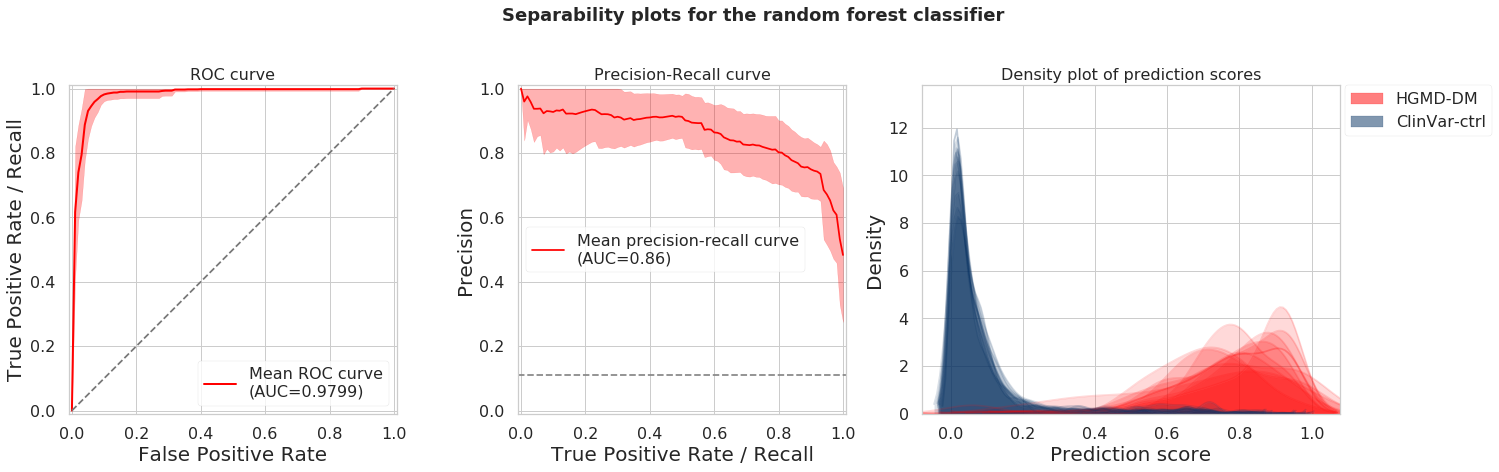

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


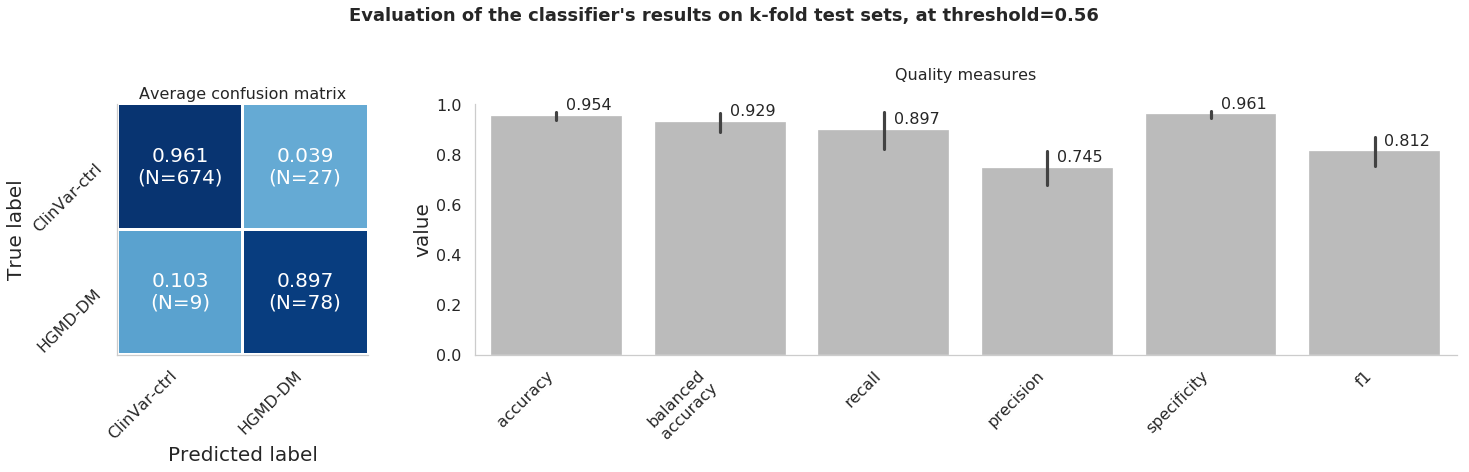

CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.26 s


In [121]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    all_res_kfolds_wtargs_testImb,
                    mean_only=True,
                    class_names = class_names['HGMD-DM']['cytobandMatch'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier',
)

# FIGURE ON QUALITY OF PREDICTIONS
threshold = find_best_threshold([v[0] for v in all_res_kfolds_wtargs_testImb],
                                [v[1] for v in all_res_kfolds_wtargs_testImb],
                                scorer=sklearn.metrics.f1_score
                               )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in all_res_kfolds_wtargs_testImb],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in all_res_kfolds_wtargs_testImb],
                             normalize=True,
                             class_names=class_names['HGMD-DM']['cytobandMatch'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
)

#### Chromosome-aware cross-validation

In [124]:
tmp_X = all_X_dfs['HGMD-DM']['cytobandMatch'].assign(cytoband=lambda df: df['chrom']+df['cytoband'])
tmp_y = pd.Series(all_y_arrs['HGMD-DM']['cytobandMatch'])

In [125]:
%%time
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs_testImb = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols1,
                                                    category='chrom',
                                                    K=10,
                                                    get_proba=True,
                                                    test_imb_ratio=0.125
                                                    )


create_model_lib.export_kfolds_results(all_res_kfolds_wtargs_testImb, path_model+'/chromosomeAware10Folds_wTargs_testImb12.5/')

2019-09-04 14:23:03 - split 1 : train size : 54,576 ((+)=1.5%)test size : 549 ((+)=11.1%)
	2019-09-04 14:23:06 - Test evaluation.
2019-09-04 14:23:07 - split 2 : train size : 65,729 ((+)=1.1%)test size : 1,368 ((+)=11.1%)
	2019-09-04 14:23:10 - Test evaluation.
2019-09-04 14:23:10 - split 3 : train size : 57,788 ((+)=1.42%)test size : 495 ((+)=11.1%)
	2019-09-04 14:23:13 - Test evaluation.
2019-09-04 14:23:14 - split 4 : train size : 57,449 ((+)=1.34%)test size : 972 ((+)=11.1%)
	2019-09-04 14:23:17 - Test evaluation.
2019-09-04 14:23:18 - split 5 : train size : 65,774 ((+)=1.21%)test size : 747 ((+)=11.1%)
	2019-09-04 14:23:21 - Test evaluation.
2019-09-04 14:23:21 - split 6 : train size : 62,773 ((+)=1.34%)test size : 342 ((+)=11.1%)
	2019-09-04 14:23:24 - Test evaluation.
2019-09-04 14:23:25 - split 7 : train size : 63,576 ((+)=1.18%)test size : 1,134 ((+)=11.1%)
	2019-09-04 14:23:28 - Test evaluation.
2019-09-04 14:23:29 - split 8 : train size : 57,786 ((+)=1.34%)test size : 954 ((

In [126]:
%%time
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs_notestImb = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols1,
                                                    category='chrom',
                                                    K=10,
                                                    get_proba=True,
                                                    #test_imb_ratio=0.125
                                                    )


create_model_lib.export_kfolds_results(all_res_kfolds_wtargs_notestImb, path_model+'/chromosomeAware10Folds_wTargs_notestImb/')

2019-09-04 14:27:29 - split 1 : train size : 58,274 ((+)=1.24%)test size : 9,693 ((+)=1.6%)
	2019-09-04 14:27:32 - Test evaluation.
2019-09-04 14:27:33 - split 2 : train size : 58,785 ((+)=1.08%)test size : 9,182 ((+)=2.66%)
	2019-09-04 14:27:36 - Test evaluation.
2019-09-04 14:27:37 - split 3 : train size : 61,951 ((+)=1.32%)test size : 6,016 ((+)=0.964%)
	2019-09-04 14:27:40 - Test evaluation.
2019-09-04 14:27:41 - split 4 : train size : 61,344 ((+)=1.29%)test size : 6,623 ((+)=1.31%)
	2019-09-04 14:27:44 - Test evaluation.
2019-09-04 14:27:45 - split 5 : train size : 61,420 ((+)=1.33%)test size : 6,547 ((+)=0.932%)
	2019-09-04 14:27:48 - Test evaluation.
2019-09-04 14:27:48 - split 6 : train size : 64,015 ((+)=1.27%)test size : 3,952 ((+)=1.67%)
	2019-09-04 14:27:52 - Test evaluation.
2019-09-04 14:27:52 - split 7 : train size : 62,704 ((+)=1.32%)test size : 5,263 ((+)=0.931%)
	2019-09-04 14:27:55 - Test evaluation.
2019-09-04 14:27:56 - split 8 : train size : 60,440 ((+)=1.41%)test

In [127]:
%%time
clf = sklearn.base.clone(pipeline2, safe=True)


all_res_kfolds_wotargs_testImb = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols2,
                                                    category='chrom',
                                                    K=10,
                                                    get_proba=True,
                                                    test_imb_ratio=0.125
                                                    )

create_model_lib.export_kfolds_results(all_res_kfolds_wotargs_testImb, path_model+'/chromosomeAware10Folds_woTargs_testImb12.5/')

2019-09-04 14:29:51 - split 1 : train size : 54,812 ((+)=1.35%)test size : 1,242 ((+)=11.1%)
	2019-09-04 14:29:54 - Test evaluation.
2019-09-04 14:29:54 - split 2 : train size : 62,298 ((+)=1.3%)test size : 639 ((+)=11.1%)
	2019-09-04 14:29:57 - Test evaluation.
2019-09-04 14:29:58 - split 3 : train size : 65,639 ((+)=1.24%)test size : 558 ((+)=11.1%)
	2019-09-04 14:30:01 - Test evaluation.
2019-09-04 14:30:02 - split 4 : train size : 60,679 ((+)=1.24%)test size : 1,152 ((+)=11.1%)
	2019-09-04 14:30:05 - Test evaluation.
2019-09-04 14:30:05 - split 5 : train size : 60,481 ((+)=1.27%)test size : 999 ((+)=11.1%)
	2019-09-04 14:30:08 - Test evaluation.
2019-09-04 14:30:09 - split 6 : train size : 65,456 ((+)=1.3%)test size : 261 ((+)=11.1%)
	2019-09-04 14:30:12 - Test evaluation.
2019-09-04 14:30:13 - split 7 : train size : 59,640 ((+)=1.38%)test size : 495 ((+)=11.1%)
	2019-09-04 14:30:16 - Test evaluation.
2019-09-04 14:30:17 - split 8 : train size : 62,583 ((+)=1.35%)test size : 306 ((

In [128]:
%%time
clf = sklearn.base.clone(pipeline2, safe=True)


all_res_kfolds_wotargs_notestImb = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols2,
                                                    category='chrom',
                                                    K=10,
                                                    get_proba=True,
                                                    #test_imb_ratio=0.125
                                                    )

create_model_lib.export_kfolds_results(all_res_kfolds_wotargs_notestImb, path_model+'/chromosomeAware10Folds_woTargs_notestImb/')

2019-09-04 14:32:58 - split 1 : train size : 58,904 ((+)=1.34%)test size : 9,063 ((+)=0.993%)
	2019-09-04 14:33:01 - Test evaluation.
2019-09-04 14:33:02 - split 2 : train size : 61,816 ((+)=1.33%)test size : 6,151 ((+)=0.927%)
	2019-09-04 14:33:05 - Test evaluation.
2019-09-04 14:33:05 - split 3 : train size : 57,634 ((+)=1.24%)test size : 10,333 ((+)=1.56%)
	2019-09-04 14:33:08 - Test evaluation.
2019-09-04 14:33:09 - split 4 : train size : 65,118 ((+)=1.05%)test size : 2,849 ((+)=6.81%)
	2019-09-04 14:33:12 - Test evaluation.
2019-09-04 14:33:13 - split 5 : train size : 60,545 ((+)=1.39%)test size : 7,422 ((+)=0.499%)
	2019-09-04 14:33:16 - Test evaluation.
2019-09-04 14:33:17 - split 6 : train size : 58,018 ((+)=1.31%)test size : 9,949 ((+)=1.18%)
	2019-09-04 14:33:20 - Test evaluation.
2019-09-04 14:33:21 - split 7 : train size : 62,553 ((+)=1.38%)test size : 5,414 ((+)=0.277%)
	2019-09-04 14:33:24 - Test evaluation.
2019-09-04 14:33:25 - split 8 : train size : 60,948 ((+)=1.34%)t

#### Full models

In [80]:
# Train full model and export.
finale_model = sklearn.base.clone(pipeline1, safe=True)
finale_model.fit(all_X_dfs['HGMD-DM']['cytobandMatch'].loc[:,red_cols1],
                 all_y_arrs['HGMD-DM']['cytobandMatch'])

# No need to export the sample indexes : one just need to load the X dataframes, the model, and use the get_sample_idx functions from each tree.
joblib.dump(finale_model, path_model+'/full-model_wTargs.pkl', compress=9)

with open(path_model+'/full-model_wTargs_columns.txt','w') as pf:
    for c in red_cols1:
        pf.write(c)
        pf.write('\n')

In [81]:
# Train full model and export.
finale_model = sklearn.base.clone(pipeline2, safe=True)
finale_model.fit(all_X_dfs['HGMD-DM']['cytobandMatch'].loc[:,red_cols2],
                 all_y_arrs['HGMD-DM']['cytobandMatch'])

# No need to export the sample indexes : one just need to load the X dataframes, the model, and use the get_sample_idx functions from each tree.
joblib.dump(finale_model, path_model+'/full-model_woTargs.pkl', compress=9)

with open(path_model+'/full-model_woTargs_columns.txt','w') as pf:
    for c in red_cols2:
        pf.write(c)
        pf.write('\n')

### HGMD-DM - distance

In [119]:
path_model = "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_distanceMatch/training_model/"

#### Simple k-fold

In [28]:
splitter = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=True)

In [30]:
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs = ML_tests.stratifiedkfold_predict(
                                            clf,
                                            all_X_dfs['HGMD-DM']['distanceMatch'].loc[:,red_cols1],
                                            pd.Series(all_y_arrs['HGMD-DM']['distanceMatch']),
                                            features=red_cols1,
                                            splitter=splitter,
                                            get_proba=True,
                                            #test_imb_ratio=0.126
                                            )

2019-06-08 15:54:18 - split 1 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:20 - Test evaluation.


2019-06-08 15:54:20 - split 2 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:22 - Test evaluation.


2019-06-08 15:54:22 - split 3 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:24 - Test evaluation.


2019-06-08 15:54:24 - split 4 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:26 - Test evaluation.


2019-06-08 15:54:26 - split 5 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:28 - Test evaluation.


2019-06-08 15:54:28 - split 6 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:30 - Test evaluation.


2019-06-08 15:54:30 - split 7 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:32 - Test evaluation.


2019-06-08 15:54:32 - split 8 : train size: 6,287 ((+)=12.6%) ; test 

In [31]:
clf = sklearn.base.clone(pipeline2, safe=True)

all_res_kfolds_wotargs = ML_tests.stratifiedkfold_predict(
                                            clf,
                                            all_X_dfs['HGMD-DM']['distanceMatch'].loc[:,red_cols2],
                                            pd.Series(all_y_arrs['HGMD-DM']['distanceMatch']),
                                            features=red_cols2,
                                            splitter=splitter,
                                            get_proba=True,
                                            #test_imb_ratio=0.126
                                            )

2019-06-08 15:54:38 - split 1 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:39 - Test evaluation.


2019-06-08 15:54:40 - split 2 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:41 - Test evaluation.


2019-06-08 15:54:42 - split 3 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:43 - Test evaluation.


2019-06-08 15:54:44 - split 4 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:45 - Test evaluation.


2019-06-08 15:54:46 - split 5 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:47 - Test evaluation.


2019-06-08 15:54:48 - split 6 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:49 - Test evaluation.


2019-06-08 15:54:50 - split 7 : train size: 6,286 ((+)=12.6%) ; test size: 699 ((+)=12.6%)
	2019-06-08 15:54:51 - Test evaluation.


2019-06-08 15:54:52 - split 8 : train size: 6,287 ((+)=12.6%) ; test 

In [32]:
#export_kfolds_results(all_res_kfolds_wtargs, path_model+'/Stratified10Folds_wTargs/')
export_kfolds_results(all_res_kfolds_wotargs, path_model+'/Stratified10Folds_woTargs/')

Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_wTargs//kfold_00//y_test.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_wTargs//kfold_00//y_pred.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_wTargs//kfold_00//test_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_wTargs//kfold_00//train_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_wTargs//kfold_00//model.pkl"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-no

Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_woTargs//kfold_00//y_test.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_woTargs//kfold_00//y_pred.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_woTargs//kfold_00//test_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_woTargs//kfold_00//train_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//Stratified10Folds_woTargs//kfold_00//model.pkl"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/HGMD-DM_ClinV

In [ ]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    all_res_kfolds_wtargs,
                    mean_only=True,
                    class_names = class_names['HGMD-DM']['cytobandMatch'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier',
)

# FIGURE ON QUALITY OF PREDICTIONS
threshold = find_best_threshold([v[0] for v in all_res_kfolds_wtargs],
                                [v[1] for v in all_res_kfolds_wtargs],
                                scorer=sklearn.metrics.f1_score
                               )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in all_res_kfolds_wtargs],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in all_res_kfolds_wtargs],
                             normalize=True,
                             class_names=class_names['HGMD-DM']['cytobandMatch'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
)

In [ ]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    all_res_kfolds_wotargs,
                    mean_only=True,
                    class_names = class_names['HGMD-DM']['cytobandMatch'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier',
)

# FIGURE ON QUALITY OF PREDICTIONS
threshold = find_best_threshold([v[0] for v in all_res_kfolds_wotargs],
                                [v[1] for v in all_res_kfolds_wotargs],
                                scorer=sklearn.metrics.f1_score
                               )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in all_res_kfolds_wotargs],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in all_res_kfolds_wotargs],
                             normalize=True,
                             class_names=class_names['HGMD-DM']['cytobandMatch'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
)

#### Cytoband-aware cross-validation

In [60]:
tmp_X = all_X_dfs['HGMD-DM']['distanceMatch'].assign(cytoband=lambda df: df['chrom']+df['cytoband'])
tmp_y = pd.Series(all_y_arrs['HGMD-DM']['distanceMatch'])

In [37]:
# with target associations
clf = sklearn.base.clone(pipeline1, safe=True)

all_res_kfolds_wtargs = categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols1,
                                                    category='cytoband',
                                                    K=10,
                                                    get_proba=True,
                                                    #test_imb_ratio=0.126
                                                    )

/users/ldog/moyon/anaconda3/envs/dnm_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


2019-06-08 16:04:06 - split 1 : train size : 6,216 ((+)=12.7%)test size : 769 ((+)=11.6%)
	2019-06-08 16:04:08 - Test evaluation.
2019-06-08 16:04:08 - split 2 : train size : 6,303 ((+)=12.0%)test size : 682 ((+)=17.7%)
	2019-06-08 16:04:10 - Test evaluation.
2019-06-08 16:04:10 - split 3 : train size : 6,243 ((+)=12.9%)test size : 742 ((+)=9.3%)
	2019-06-08 16:04:12 - Test evaluation.
2019-06-08 16:04:12 - split 4 : train size : 6,260 ((+)=12.9%)test size : 725 ((+)=9.24%)
	2019-06-08 16:04:14 - Test evaluation.
2019-06-08 16:04:14 - split 5 : train size : 6,392 ((+)=13.0%)test size : 593 ((+)=8.26%)
	2019-06-08 16:04:16 - Test evaluation.
2019-06-08 16:04:16 - split 6 : train size : 6,407 ((+)=13.0%)test size : 578 ((+)=8.13%)
	2019-06-08 16:04:18 - Test evaluation.
2019-06-08 16:04:18 - split 7 : train size : 5,974 ((+)=11.0%)test size : 1,011 ((+)=21.7%)
	2019-06-08 16:04:20 - Test evaluation.
2019-06-08 16:04:20 - split 8 : train size : 6,266 ((+)=12.9%)test size : 719 ((+)=9.87%)

In [62]:
%%time
clf = sklearn.base.clone(pipeline2, safe=True)


all_res_kfolds_wotargs = create_model_lib.categorical_stratified_kfold_predict(
                                                    clf,
                                                    tmp_X,
                                                    tmp_y,
                                                    features=tmp_X.columns,
                                                    use_cols = red_cols2,
                                                    category='cytoband',
                                                    K=10,
                                                    get_proba=True,
                                                    #test_imb_ratio=0.126
                                                    )

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


2019-10-24 10:46:47 - split 1 : train size : 6,270 ((+)=13.0%) | test size : 720 ((+)=8.75%)
	2019-10-24 10:46:49 - Test evaluation.
2019-10-24 10:46:50 - split 2 : train size : 6,240 ((+)=12.0%) | test size : 750 ((+)=17.5%)
	2019-10-24 10:46:52 - Test evaluation.
2019-10-24 10:46:52 - split 3 : train size : 6,363 ((+)=12.1%) | test size : 627 ((+)=17.4%)
	2019-10-24 10:46:54 - Test evaluation.
2019-10-24 10:46:55 - split 4 : train size : 6,232 ((+)=13.3%) | test size : 758 ((+)=6.73%)
	2019-10-24 10:46:56 - Test evaluation.
2019-10-24 10:46:57 - split 5 : train size : 6,367 ((+)=12.5%) | test size : 623 ((+)=12.8%)
	2019-10-24 10:46:59 - Test evaluation.
2019-10-24 10:46:59 - split 6 : train size : 6,305 ((+)=12.7%) | test size : 685 ((+)=10.8%)
	2019-10-24 10:47:01 - Test evaluation.
2019-10-24 10:47:02 - split 7 : train size : 6,196 ((+)=13.0%) | test size : 794 ((+)=9.19%)
	2019-10-24 10:47:04 - Test evaluation.
2019-10-24 10:47:04 - split 8 : train size : 6,207 ((+)=12.0%) | test

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


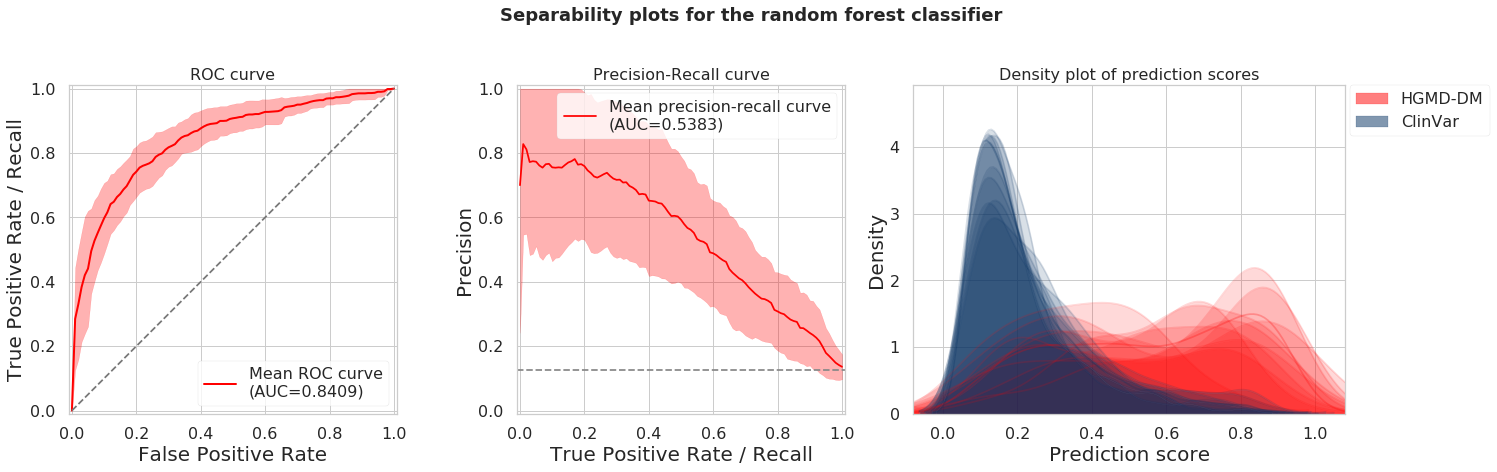

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

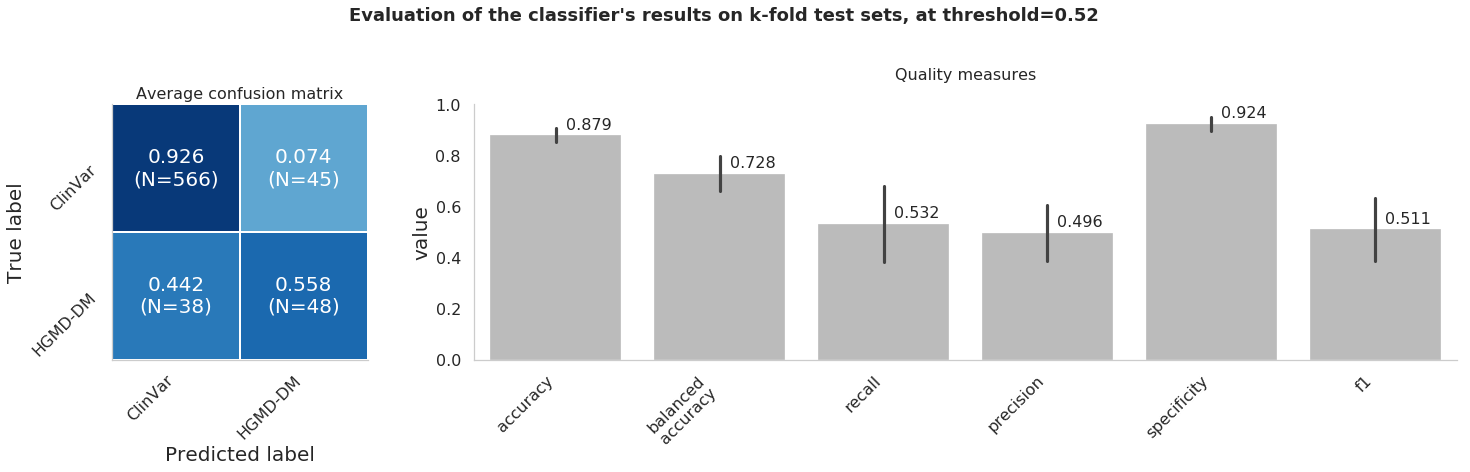

CPU times: user 1.07 s, sys: 8 ms, total: 1.08 s
Wall time: 1.08 s


In [115]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    all_res_kfolds_wotargs,
                    mean_only=True,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier',
                    #savefig_file="/users/ldog/moyon/Thesis/HGMD-DM_RANDOM_separability_curves.svg"
                    )

# FIGURE ON QUALITY OF PREDICTIONS
threshold = create_model_lib.find_best_threshold([v[0] for v in all_res_kfolds_wotargs],
                                [v[1] for v in all_res_kfolds_wotargs],
                                scorer=sklearn.metrics.f1_score
                               )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in all_res_kfolds_wotargs],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in all_res_kfolds_wotargs],
                             normalize=True,
                             class_names=['ClinVar','HGMD-DM'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
                             #savefig_file="/users/ldog/moyon/Thesis/writting/FINSURF_ARTICLE/00_pre-submission/02_figures/figure_evaluating_classifiers/panel_HGMD-DM_GENCODE_quality-measures_F1-optim.svg"
)

In [120]:
#create_model_lib.export_kfolds_results(all_res_kfolds_wtargs, path_model+'/CytobandAware10Folds_wTargs/')
create_model_lib.export_kfolds_results(all_res_kfolds_wotargs, path_model+'/CytobandAware10Folds_woTargs/')

Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//y_test.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//y_pred.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//test_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//train_index.txt"
Created file "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_distanceMatch/training_model//CytobandAware10Folds_woTargs//kfold_00//model.pkl"
Created file "/ki

#### Full models

In [42]:
# Train full model and export.
finale_model = sklearn.base.clone(pipeline1, safe=True)
finale_model.fit(all_X_dfs['HGMD-DM']['cytobandMatch'].loc[:,red_cols1],
                 all_y_arrs['HGMD-DM']['cytobandMatch'])

# No need to export the sample indexes : one just need to load the X dataframes, the model, and use the get_sample_idx functions from each tree.
joblib.dump(finale_model, path_model+'/full-model_wTargs.pkl', compress=9)

with open(path_model+'/full-model_wTargs_columns.txt','w') as pf:
    for c in red_cols1:
        pf.write(c)
        pf.write('\n')

In [43]:
# Train full model and export.
finale_model = sklearn.base.clone(pipeline2, safe=True)
finale_model.fit(all_X_dfs['HGMD-DM']['distanceMatch'].loc[:,red_cols2],
                 all_y_arrs['HGMD-DM']['distanceMatch'])

# No need to export the sample indexes : one just need to load the X dataframes, the model, and use the get_sample_idx functions from each tree.
joblib.dump(finale_model, path_model+'/full-model_woTargs.pkl', compress=9)

with open(path_model+'/full-model_woTargs_columns.txt','w') as pf:
    for c in red_cols2:
        pf.write(c)
        pf.write('\n')

# Model comparison and cross-performance

In [19]:
def cross_training_sets_evaluation(kfold_datasets, X_current, y_current, X_cross, y_cross, test_imb_ratio=None):
    cross_dataset_kf_results = []

    X_cross_rowid_pos = X_cross.loc[y_cross==1,'row_id']
    X_cross_rowid_neg = X_cross.loc[y_cross==0,'row_id']

    for i, kf_res in enumerate(kfold_datasets):
        print(("{} - split {} : ").format(datetime.datetime.now().replace(microsecond=0),i+1))
        y, y_predict, test_indices, train_indices, kfold_model = kf_res

        # The goal here is to filter from the X_cytoband the samples that were used for the training of this model.
        # Then the evaluation can be performed on the rest of the X_cytoband dataset (positive and negative included)

        X_train = X_current.loc[train_indices,:]
        y_train = y_current[train_indices]
        X_train_pos_rowid = X_train.loc[y_train==1,'row_id'].values
        X_train_neg_rowid = X_train.loc[y_train==0,'row_id'].values

        # Here : get the row_id values for the positives in X_current ;
        # then use the index of the Series to keep the samples whom row_id is not in the X_random_train row_ids.
        X_cross_indices_pos_test = X_cross_rowid_pos.index.values[(~X_cross_rowid_pos.isin(X_train_pos_rowid)).values]

        X_cross_indices_neg_test = X_cross_rowid_neg.index.values[(~X_cross_rowid_neg.isin(X_train_neg_rowid)).values]

        print(("\t{} - building the X_cross table of samples in X_cross that were not used for training in X_current"
              ).format(datetime.datetime.now().replace(microsecond=0)))
        X_test_cross = pd.concat([
                        X_cross.loc[
                            X_cross_indices_pos_test,
                            :],
                        X_cross.loc[
                            X_cross_indices_neg_test,
                            :],
        ],axis=0)
        y_test_cross = y_cross[X_test_cross.index.values]

        print(("\t{} - performing imbalance correction."
              ).format(datetime.datetime.now().replace(microsecond=0))
             )
        # Don't forget to reduce the % of negatives by random downsampling.
        if test_imb_ratio is not None:
            rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=test_imb_ratio)
            print(("\t\t{} - Fit resampling"
                  ).format(datetime.datetime.now().replace(microsecond=0))
                 )
            _ = rus.fit_resample(X_test_cross.iloc[:,:4].replace(np.nan,0),y_test_cross)
            print(("\t\t{} - Get indices"
                  ).format(datetime.datetime.now().replace(microsecond=0))
                 )
            
            und_test_cross_idx = X_test_cross.index.values[rus.sample_indices_]
            print(("\t\t{} - Build sub-sampled dataframe"
                  ).format(datetime.datetime.now().replace(microsecond=0))
                 )
                  
            X_test_cross_und = X_test_cross.loc[und_test_cross_idx,:]
            y_test_cross_und = pd.Series(y_test_cross, index=X_test_cross.index.values).loc[und_test_cross_idx].values
        else:
            X_test_cross_und = X_test_cross
            y_test_cross_und = y_test_cross
            und_test_cross_idx = X_test_cross_und.index.values

        print(("\t{} - split {} : "
               "test size: {:,} ((+)={:.3}%)"
               ).format(datetime.datetime.now().replace(microsecond=0),
                        i+1,
                        len(und_test_cross_idx),
                        (y_test_cross_und.sum()/y_test_cross_und.shape[0])*100
                       )
             )

        # And now apply the model on this "test" dataset.
        # Store the results in a tuple structure similar to the kfolds.

        preds_cross = kfold_model.predict_proba(X_test_cross_und)

        cross_dataset_kf_results.append((y_test_cross_und, preds_cross, und_test_cross_idx, None, None))

        print("\n")
    
    return cross_dataset_kf_results

## Load Data

In [23]:
all_X_dfs = {'HGMD-DM':{},'eQTLs-OMIM':{}, 'eQTLs-ASD-OT':{}, 'eQTLs-ASD-SFARI':{}}
all_y_arrs = {'HGMD-DM':{},'eQTLs-OMIM':{}, 'eQTLs-ASD-OT':{}, 'eQTLs-ASD-SFARI':{}}
class_names = {'HGMD-DM':{},'eQTLs':{}}

### HGMD-DM

##### HGMD-DM - noMatch

In [24]:
%%time
X, y = load_model_dataset("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model/datasets/")
y = np.array(y)

all_X_dfs['HGMD-DM']['noMatch'] = X
all_y_arrs['HGMD-DM']['noMatch'] = y
class_names['HGMD-DM']['noMatch'] = ['ClinVar-ctrl','HGMD-DM']

print(("Original dataset contains {:,} samples, of which {:.3}% are positive samples.\n"
      ).format(all_X_dfs['HGMD-DM']['noMatch'].shape[0], 100*all_y_arrs['HGMD-DM']['noMatch'].sum()/len(all_y_arrs['HGMD-DM']['noMatch'])))

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


Original dataset contains 31,517,008 samples, of which 0.00279% are positive samples.

CPU times: user 10min 46s, sys: 3min 2s, total: 13min 49s
Wall time: 10min 45s


##### HGMD-DM - GENCODE

In [17]:
%%time
X, y = load_model_dataset("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_gencodeMatch/training_model/datasets/")
y = np.array(y)

all_X_dfs['HGMD-DM']['gencodeMatch'] = X
all_y_arrs['HGMD-DM']['gencodeMatch'] = y
class_names['HGMD-DM']['gencodeMatch'] = ['ClinVar-ctrl','HGMD-DM']

print(("Original dataset contains {:,} samples, of which {:.3}% are positive samples.\n"
      ).format(all_X_dfs['HGMD-DM']['gencodeMatch'].shape[0], 100*all_y_arrs['HGMD-DM']['gencodeMatch'].sum()/len(all_y_arrs['HGMD-DM']['gencodeMatch'])))

Original dataset contains 220,183 samples, of which 0.399% are positive samples.

CPU times: user 4.92 s, sys: 4.22 s, total: 9.14 s
Wall time: 9.15 s


##### HGMD-DM - cytobands

In [25]:
%%time
X, y = load_model_dataset("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model//datasets/")
y = np.array(y)

all_X_dfs['HGMD-DM']['cytobandMatch'] = X
all_y_arrs['HGMD-DM']['cytobandMatch'] = y
class_names['HGMD-DM']['cytobandMatch'] = ['ClinVar-ctrl','HGMD-DM']

print("N_samples: {:,} ({:.3}% positives)\n".format(all_X_dfs['HGMD-DM']['cytobandMatch'].shape[0], 100*all_y_arrs['HGMD-DM']['cytobandMatch'].sum()/len(all_y_arrs['HGMD-DM']['cytobandMatch'])))

N_samples: 67,967 (1.29% positives)

CPU times: user 1.46 s, sys: 8 ms, total: 1.47 s
Wall time: 1.48 s


##### HGMD-DM - Distance

In [28]:
%%time
X, y = load_model_dataset("../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_distanceMatch/training_model/datasets/")
y = np.array(y)

all_X_dfs['HGMD-DM']['distanceMatch'] = X
all_y_arrs['HGMD-DM']['distanceMatch'] = y
class_names['HGMD-DM']['distanceMatch'] = ['ClinVar-ctrl','HGMD-DM']

print("N_samples: {:,} ({:.3}% positives)\n".format(all_X_dfs['HGMD-DM']['distanceMatch'].shape[0], 100*all_y_arrs['HGMD-DM']['distanceMatch'].sum()/len(all_y_arrs['HGMD-DM']['distanceMatch'])))

N_samples: 6,990 (12.5% positives)

CPU times: user 148 ms, sys: 8 ms, total: 156 ms
Wall time: 162 ms


## RandomMatch models

In [27]:
random_model_all_res_kfolds_wotargs_cytobased = create_model_lib.KfoldResults(name="HGMDDM",
                                                                              path="../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model/kfolds_evaluations/CytobandAware10Folds_woTargs_testImb12.5/"
                                                                             )

random_model_all_res_kfolds_wotargs_cytobased_list = list(random_model_all_res_kfolds_wotargs_cytobased.get_kfold_res_structure())

Loading all kfolds results from "../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_noMatch/training_model/kfolds_evaluations/CytobandAware10Folds_woTargs_testImb12.5/"


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


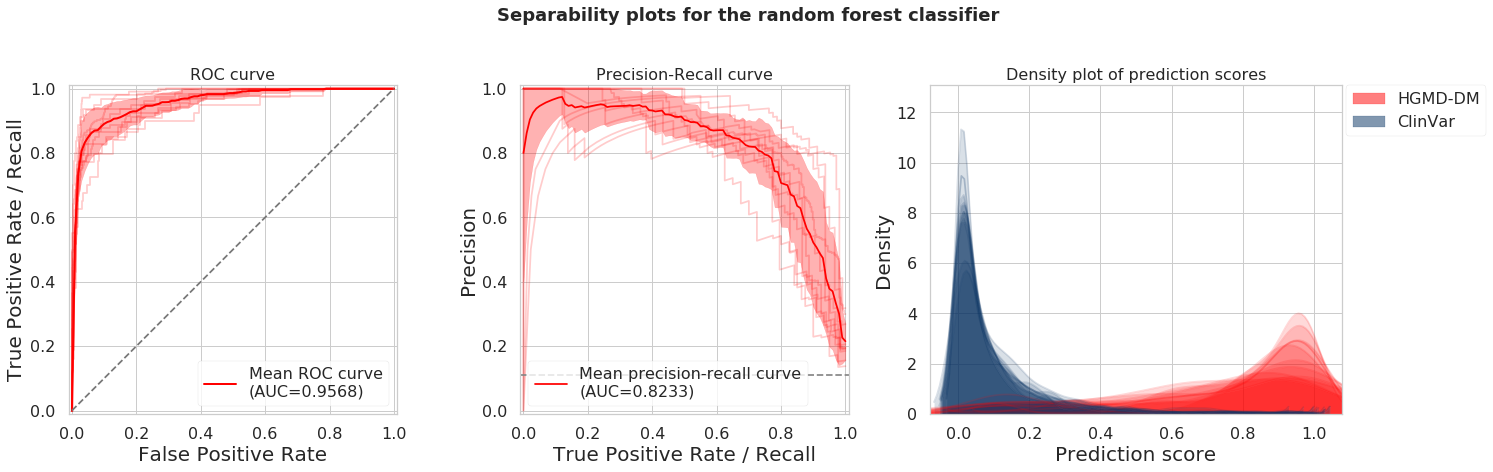

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


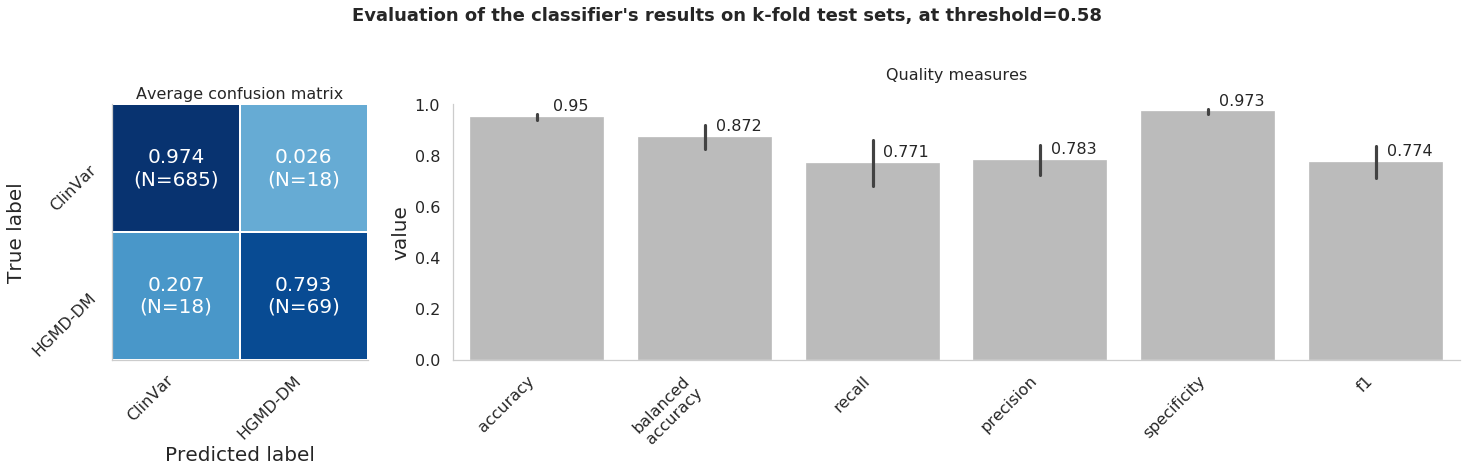

CPU times: user 1.54 s, sys: 0 ns, total: 1.54 s
Wall time: 1.9 s


In [34]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    random_model_all_res_kfolds_wotargs_cytobased_list,
                    mean_only=False,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier',
                    savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/HGMD-DM_RANDOM_separability_curves.svg"
                    )

# FIGURE ON QUALITY OF PREDICTIONS
threshold = create_model_lib.find_best_threshold([v[0] for v in random_model_all_res_kfolds_wotargs_cytobased_list],
                                [v[1] for v in random_model_all_res_kfolds_wotargs_cytobased_list],
                                scorer=sklearn.metrics.f1_score
                               )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in random_model_all_res_kfolds_wotargs_cytobased_list],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in random_model_all_res_kfolds_wotargs_cytobased_list],
                             normalize=True,
                             class_names=['ClinVar','HGMD-DM'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
                             savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/panel_HGMD-DM_RANDOM_quality-measures_F1-optim.svg"
)

### On cytomatch

In [29]:
cross_dataset_kf_results_randomModel_onCytoMatch = cross_training_sets_evaluation(random_model_all_res_kfolds_wotargs_cytobased_list,
                                                                           all_X_dfs['HGMD-DM']['noMatch'],
                                                                           all_y_arrs['HGMD-DM']['noMatch'],
                                                                           all_X_dfs['HGMD-DM']['cytobandMatch'],
                                                                           all_y_arrs['HGMD-DM']['cytobandMatch'],
                                                                           test_imb_ratio=0.125)

2020-04-23 23:31:06 - split 1 : 
	2020-04-23 23:32:05 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-23 23:32:05 - performing imbalance correction.
		2020-04-23 23:32:05 - Fit resampling
		2020-04-23 23:32:05 - Get indices
		2020-04-23 23:32:05 - Build sub-sampled dataframe
	2020-04-23 23:32:05 - split 1 : test size: 360 ((+)=11.1%)


2020-04-23 23:32:05 - split 2 : 
	2020-04-23 23:37:55 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-23 23:37:55 - performing imbalance correction.
		2020-04-23 23:37:55 - Fit resampling
		2020-04-23 23:37:55 - Get indices
		2020-04-23 23:37:55 - Build sub-sampled dataframe
	2020-04-23 23:37:55 - split 2 : test size: 2,304 ((+)=11.1%)


2020-04-23 23:37:56 - split 3 : 
	2020-04-23 23:38:44 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-23 23:38:44 - performing imbalance correction.
		

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


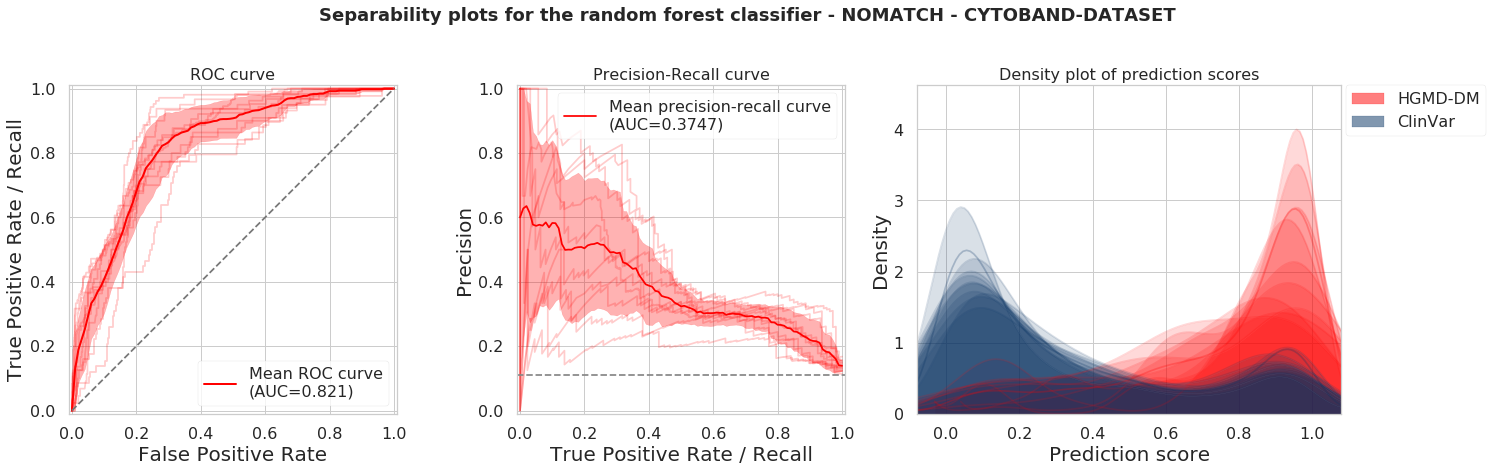

In [36]:
ML_visualization.separability_plots(
                    cross_dataset_kf_results_randomModel_onCytoMatch,
                    mean_only=False,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier - NOMATCH - CYTOBAND-DATASET',
                    savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/HGMD-DM_RANDOM_cross-validation-CYTOBANDMATCH.svg"
                    )

### On distMatch

In [30]:
cross_dataset_kf_results_randomModel_onDistMatch = cross_training_sets_evaluation(random_model_all_res_kfolds_wotargs_cytobased_list,
                                                                           all_X_dfs['HGMD-DM']['noMatch'],
                                                                           all_y_arrs['HGMD-DM']['noMatch'],
                                                                           all_X_dfs['HGMD-DM']['distanceMatch'],
                                                                           all_y_arrs['HGMD-DM']['distanceMatch'],
                                                                                 )

2020-04-23 23:44:23 - split 1 : 
	2020-04-23 23:45:08 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-23 23:45:08 - performing imbalance correction.
	2020-04-23 23:45:08 - split 1 : test size: 741 ((+)=5.4%)


2020-04-23 23:45:08 - split 2 : 
	2020-04-23 23:45:55 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-23 23:45:55 - performing imbalance correction.
	2020-04-23 23:45:55 - split 2 : test size: 1,020 ((+)=25.1%)


2020-04-23 23:45:56 - split 3 : 
	2020-04-23 23:46:43 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-23 23:46:43 - performing imbalance correction.
	2020-04-23 23:46:43 - split 3 : test size: 774 ((+)=7.49%)


2020-04-23 23:46:43 - split 4 : 
	2020-04-23 23:47:35 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-23 23:47:35 - performing imbalance c

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


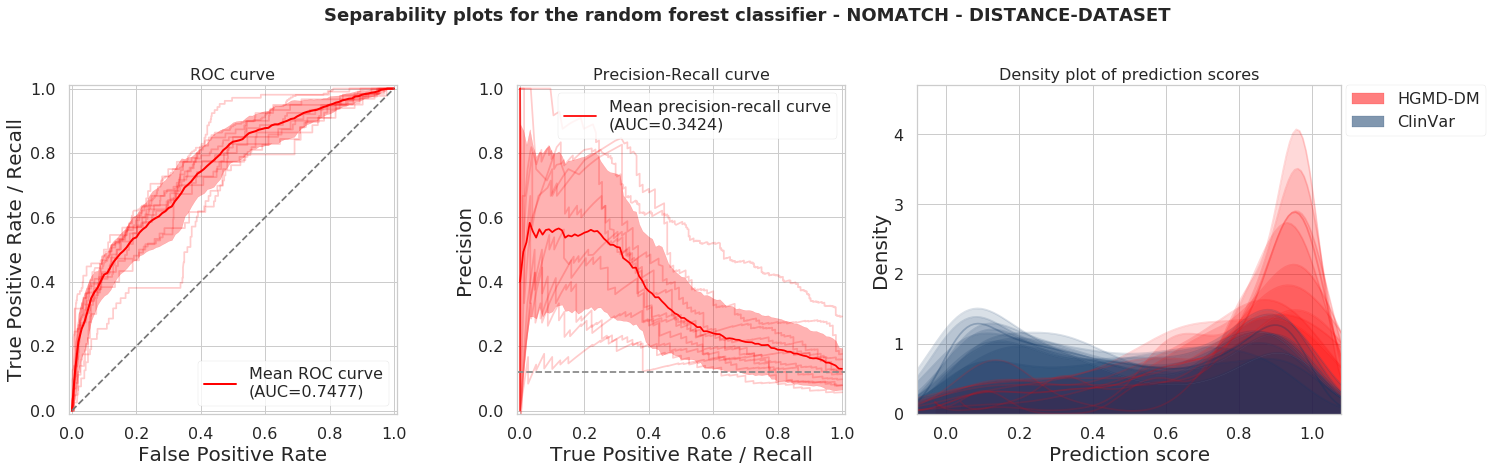

In [38]:
ML_visualization.separability_plots(
                    cross_dataset_kf_results_randomModel_onDistMatch,
                    mean_only=False,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier - NOMATCH - DISTANCE-DATASET',
                    savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/HGMD-DM_RANDOM_cross-validation-DISTANCEMATCH.svg"
                    )

## CytobandMatch models

In [39]:
path_dir = ("/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/{model}/training_model/kfolds_evaluations/{kfold_scheme}/"
           ).format(model='HGMD-DM_ClinVar-noPat_cytobandMatch',kfold_scheme='CytobandAware10Folds_woTargs_testImb12.5')

kfold_res = create_model_lib.KfoldResults(name="HGMDDM",
                                          path=path_dir)

kf_res_list = list(kfold_res.get_kfold_res_structure())

Loading all kfolds results from "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/kfolds_evaluations/CytobandAware10Folds_woTargs_testImb12.5/"


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


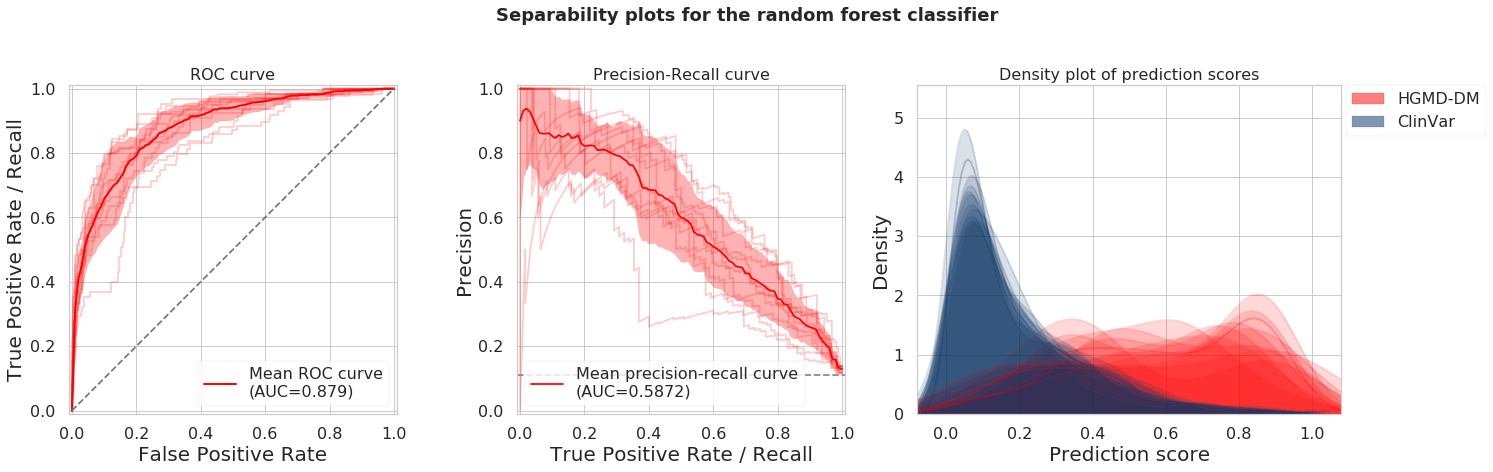

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


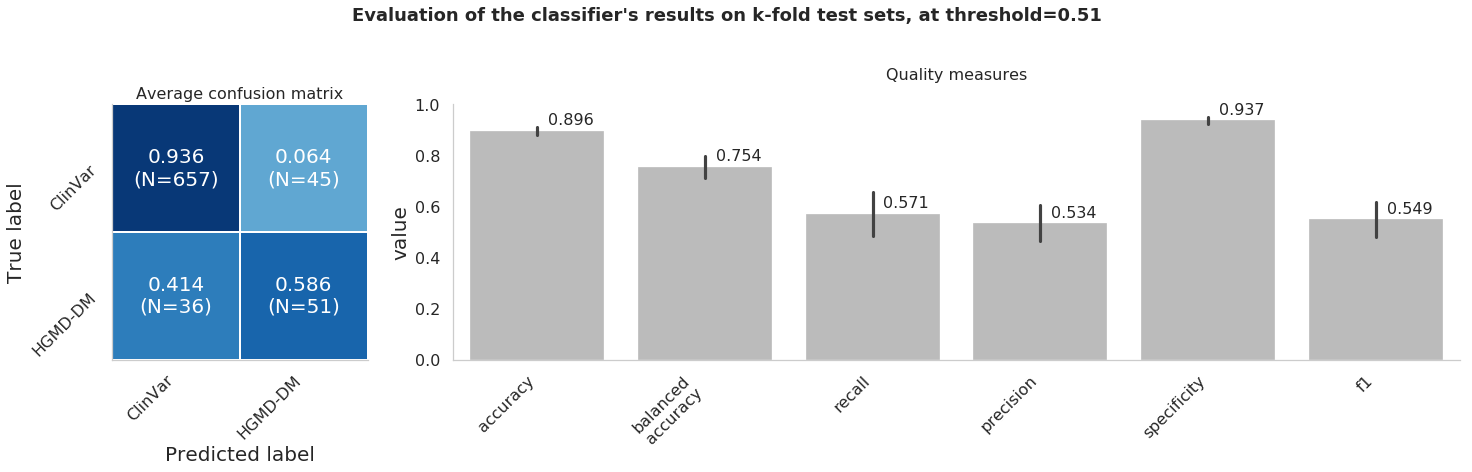

CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.69 s


In [40]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    kf_res_list,
                    mean_only=False,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier',
                    savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/HGMD-DM_CYTOBANDMATCH_separability_curves.svg"
                    )

# FIGURE ON QUALITY OF PREDICTIONS
threshold = create_model_lib.find_best_threshold([v[0] for v in kf_res_list],
                                [v[1] for v in kf_res_list],
                                scorer=sklearn.metrics.f1_score
                               )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in kf_res_list],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in kf_res_list],
                             normalize=True,
                             class_names=['ClinVar','HGMD-DM'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
                             savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/panel_HGMD-DM_CYTOBANDMATCH_quality-measures_F1-optim.svg"
)

### on NoMatch

In [43]:
cross_dataset_kf_results_cytomatch_random = cross_training_sets_evaluation(kf_res_list,
                                                                           all_X_dfs['HGMD-DM']['cytobandMatch'],
                                                                           pd.Series(all_y_arrs['HGMD-DM']['cytobandMatch']),
                                                                           all_X_dfs['HGMD-DM']['noMatch'],
                                                                           all_y_arrs['HGMD-DM']['noMatch'],
                                                                           test_imb_ratio=0.125)

2020-04-24 09:00:58 - split 1 : 
	2020-04-24 09:01:01 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-24 09:03:15 - performing imbalance correction.
		2020-04-24 09:03:15 - Fit resampling
		2020-04-24 09:03:25 - Get indices
		2020-04-24 09:03:25 - Build sub-sampled dataframe
	2020-04-24 09:15:19 - split 1 : test size: 585 ((+)=11.1%)


2020-04-24 09:15:19 - split 2 : 
	2020-04-24 09:15:22 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-24 09:19:31 - performing imbalance correction.
		2020-04-24 09:19:31 - Fit resampling
		2020-04-24 09:19:44 - Get indices
		2020-04-24 09:19:44 - Build sub-sampled dataframe
	2020-04-24 09:20:25 - split 2 : test size: 603 ((+)=11.1%)


2020-04-24 09:20:26 - split 3 : 
	2020-04-24 09:20:28 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-24 09:21:41 - performing imbalance correction.
		20

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


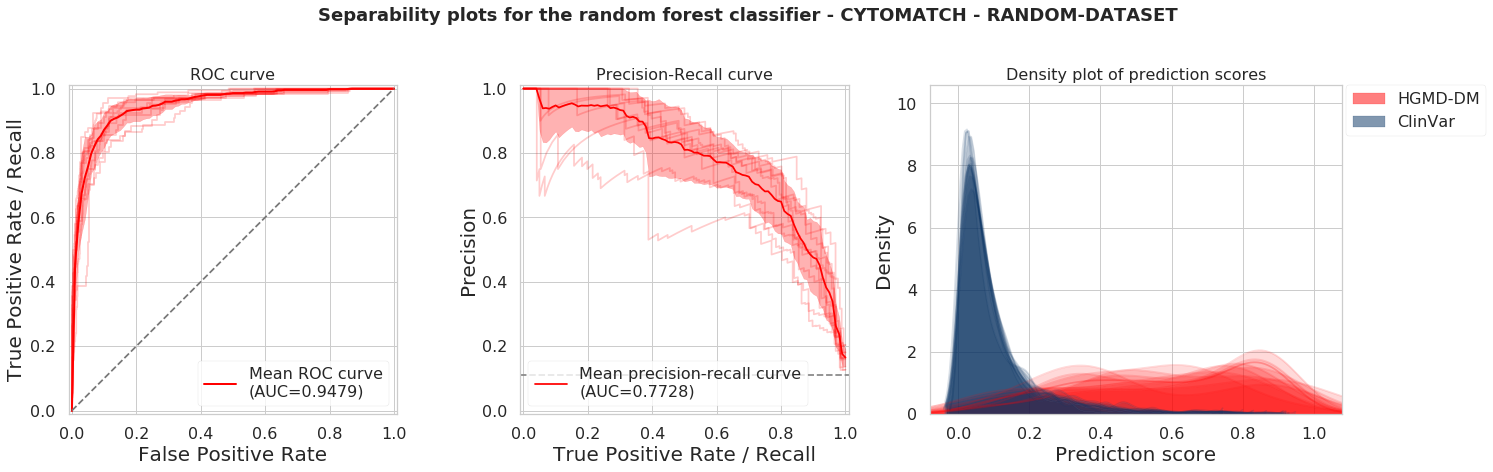

In [44]:
ML_visualization.separability_plots(
                    cross_dataset_kf_results_cytomatch_random,
                    mean_only=False,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier - CYTOMATCH - RANDOM-DATASET',
                    savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/HGMD-DM_CYTOBANDMATCH_cross-validation-RANDOMMATCH.svg"
                    )

### on DistMatch

In [41]:
cross_dataset_kf_results_cytomatch_distance = cross_training_sets_evaluation(kf_res_list,
                                                                           all_X_dfs['HGMD-DM']['cytobandMatch'],
                                                                           pd.Series(all_y_arrs['HGMD-DM']['cytobandMatch']),
                                                                           all_X_dfs['HGMD-DM']['distanceMatch'],
                                                                           all_y_arrs['HGMD-DM']['distanceMatch'],
                                                                           test_imb_ratio=0.125)

2020-04-24 08:58:46 - split 1 : 
	2020-04-24 08:58:46 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-24 08:58:46 - performing imbalance correction.
		2020-04-24 08:58:46 - Fit resampling
		2020-04-24 08:58:46 - Get indices
		2020-04-24 08:58:46 - Build sub-sampled dataframe
	2020-04-24 08:58:46 - split 1 : test size: 567 ((+)=11.1%)


2020-04-24 08:58:47 - split 2 : 
	2020-04-24 08:58:47 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-24 08:58:47 - performing imbalance correction.
		2020-04-24 08:58:47 - Fit resampling
		2020-04-24 08:58:47 - Get indices
		2020-04-24 08:58:47 - Build sub-sampled dataframe
	2020-04-24 08:58:47 - split 2 : test size: 585 ((+)=11.1%)


2020-04-24 08:58:47 - split 3 : 
	2020-04-24 08:58:47 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-24 08:58:47 - performing imbalance correction.
		20

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


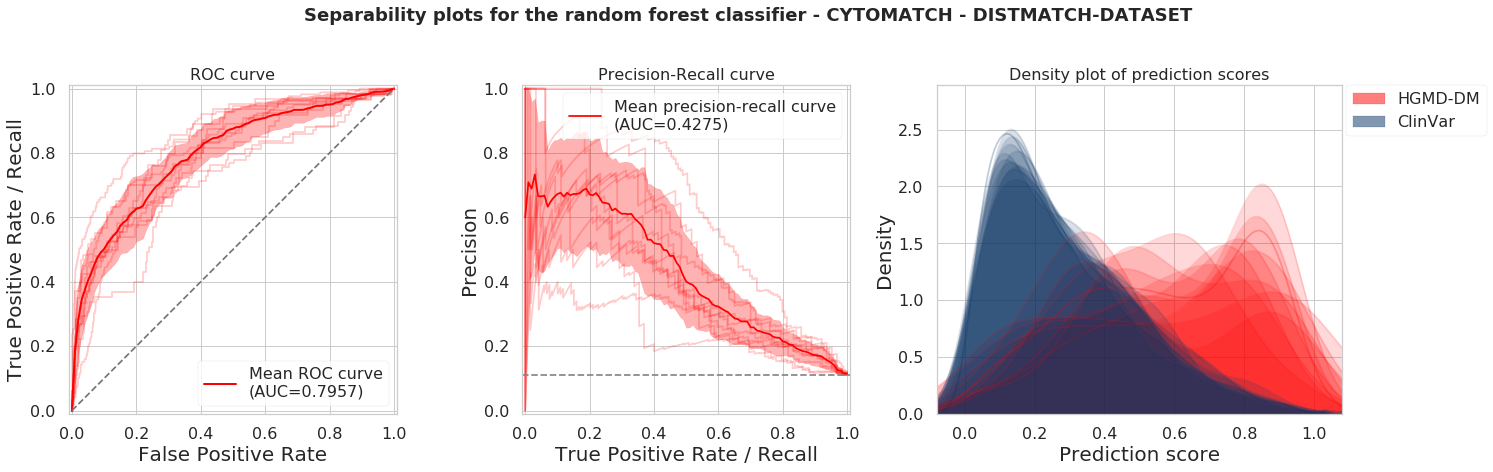

In [42]:
ML_visualization.separability_plots(
                    cross_dataset_kf_results_cytomatch_distance,
                    mean_only=False,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier - CYTOMATCH - DISTMATCH-DATASET',
                    savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/HGMD-DM_CYTOBANDMATCH_cross-validation-DISTANCEMATCH.svg"
                    )

## DistanceMatch models

In [48]:
path_dir = ("/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/{model}/training_model/kfolds_evaluations/{kfold_scheme}/"
           ).format(model='HGMD-DM_ClinVar-noPat_distanceMatch',kfold_scheme='CytobandAware10Folds_woTargs_testImb12.5')

kfold_res = create_model_lib.KfoldResults(name="HGMDDM",
                                          path=path_dir)

kf_res_list = list(kfold_res.get_kfold_res_structure())

Loading all kfolds results from "/kingdoms/dyogen/workspace5/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_distanceMatch/training_model/kfolds_evaluations/CytobandAware10Folds_woTargs_testImb12.5/"


/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


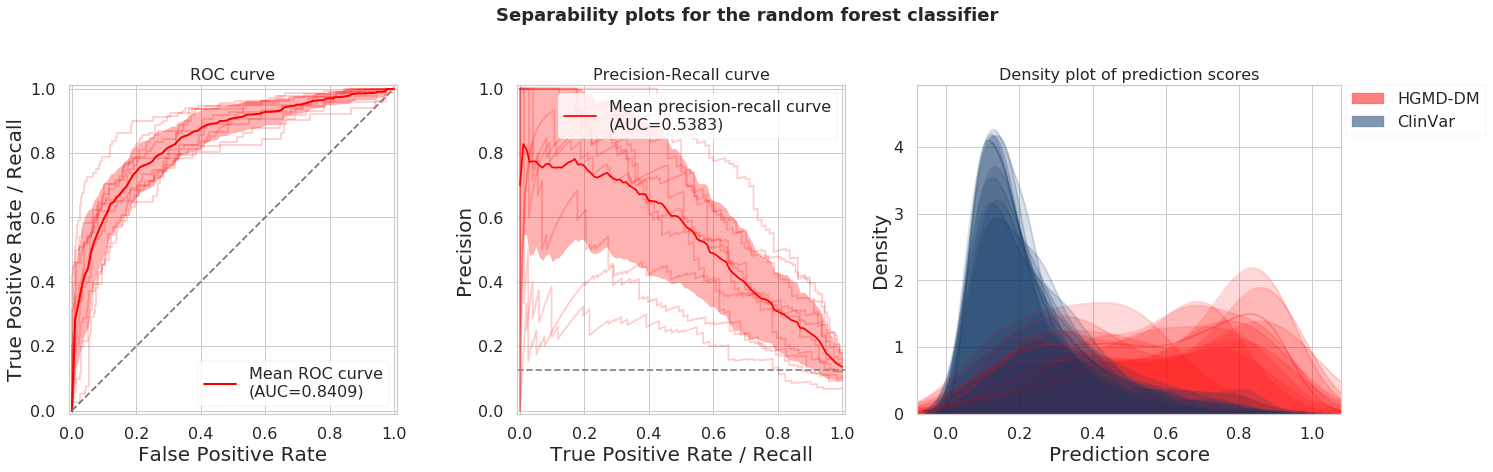

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

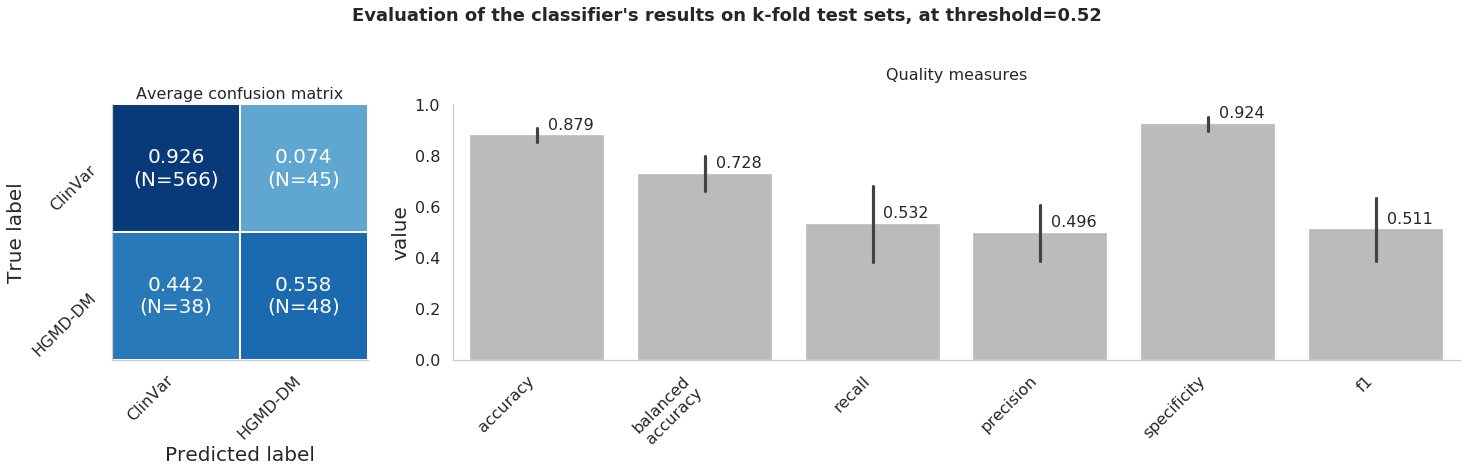

CPU times: user 2.04 s, sys: 0 ns, total: 2.04 s
Wall time: 2.31 s


In [50]:
%%time

# FIGURE ON SEPARABILITY
ML_visualization.separability_plots(
                    kf_res_list,
                    mean_only=False,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier',
                    savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/HGMD-DM_DISTANCEMATCH_separability_curves.svg"
                    )

# FIGURE ON QUALITY OF PREDICTIONS
threshold = create_model_lib.find_best_threshold([v[0] for v in kf_res_list],
                                [v[1] for v in kf_res_list],
                                scorer=sklearn.metrics.f1_score
                               )

ML_visualization.quality_classification_plots(
                             [kf_res[0] for kf_res in kf_res_list],
                             [(kf_res[1][:,1]>threshold).astype(int) for kf_res in kf_res_list],
                             normalize=True,
                             class_names=['ClinVar','HGMD-DM'],
                             main_title="Evaluation of the classifier's results on k-fold test sets, at threshold={:.3}".format(threshold),
                             savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/panel_HGMD-DM_DISTANCEMATCH_quality-measures_F1-optim.svg"
)

### On Random Match

In [51]:
cross_dataset_kf_results_distmatch_onRandomMatch = cross_training_sets_evaluation(kf_res_list,
                                                                           all_X_dfs['HGMD-DM']['distanceMatch'],
                                                                           all_y_arrs['HGMD-DM']['distanceMatch'],
                                                                           all_X_dfs['HGMD-DM']['noMatch'],
                                                                           all_y_arrs['HGMD-DM']['noMatch'],
                                                                            test_imb_ratio=0.125)

2020-04-28 20:39:46 - split 1 : 
	2020-04-28 20:39:49 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-28 20:59:10 - performing imbalance correction.
		2020-04-28 20:59:10 - Fit resampling
		2020-04-28 20:59:22 - Get indices
		2020-04-28 20:59:22 - Build sub-sampled dataframe
	2020-04-28 21:00:30 - split 1 : test size: 594 ((+)=11.1%)


2020-04-28 21:00:30 - split 2 : 
	2020-04-28 21:00:32 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-28 21:02:22 - performing imbalance correction.
		2020-04-28 21:02:22 - Fit resampling
		2020-04-28 21:02:35 - Get indices
		2020-04-28 21:02:35 - Build sub-sampled dataframe
	2020-04-28 21:03:18 - split 2 : test size: 1,206 ((+)=11.1%)


2020-04-28 21:03:18 - split 3 : 
	2020-04-28 21:03:21 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-28 21:04:31 - performing imbalance correction.
		

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


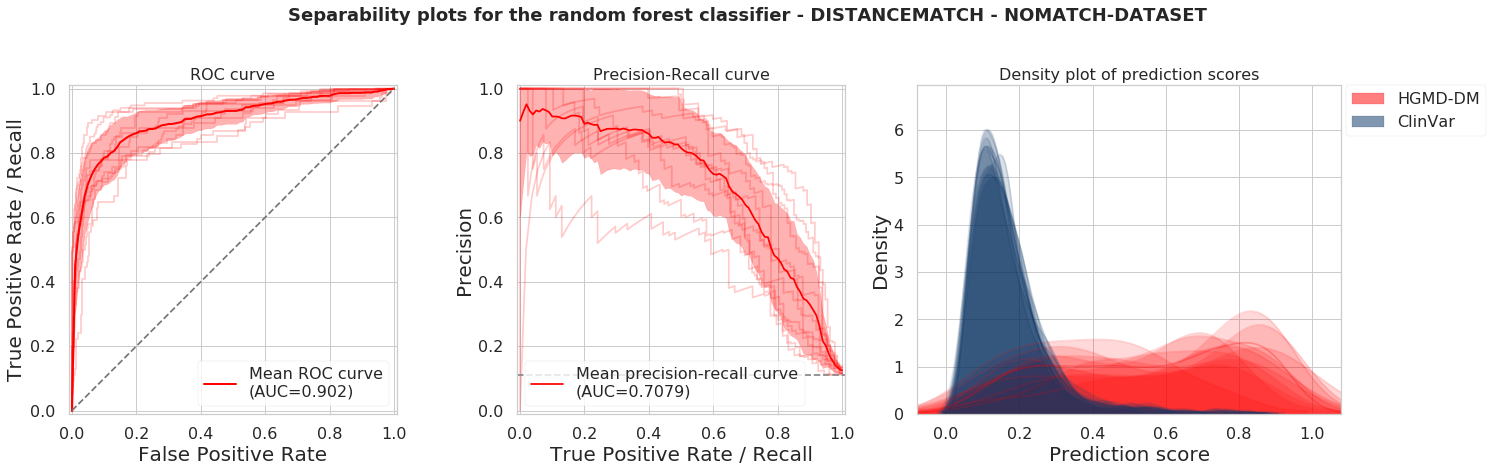

In [53]:
ML_visualization.separability_plots(
                    cross_dataset_kf_results_distmatch_onRandomMatch,
                    mean_only=False,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier - DISTANCEMATCH - NOMATCH-DATASET',
                    savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/HGMD-DM_DISTANCEMATCH_cross-validation-NOMATCH.svg"
                    )

### On Cytomatch

In [54]:
cross_dataset_kf_results_distmatch_onCytobandMatch = cross_training_sets_evaluation(kf_res_list,
                                                                           all_X_dfs['HGMD-DM']['distanceMatch'],
                                                                           all_y_arrs['HGMD-DM']['distanceMatch'],
                                                                           all_X_dfs['HGMD-DM']['cytobandMatch'],
                                                                           all_y_arrs['HGMD-DM']['cytobandMatch'],
                                                                            test_imb_ratio=0.125)

2020-04-28 21:56:28 - split 1 : 
	2020-04-28 21:56:28 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-28 21:56:31 - performing imbalance correction.
		2020-04-28 21:56:31 - Fit resampling
		2020-04-28 21:56:32 - Get indices
		2020-04-28 21:56:32 - Build sub-sampled dataframe
	2020-04-28 21:56:32 - split 1 : test size: 576 ((+)=11.1%)


2020-04-28 21:56:32 - split 2 : 
	2020-04-28 21:56:32 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-28 21:56:32 - performing imbalance correction.
		2020-04-28 21:56:32 - Fit resampling
		2020-04-28 21:56:32 - Get indices
		2020-04-28 21:56:32 - Build sub-sampled dataframe
	2020-04-28 21:56:33 - split 2 : test size: 1,188 ((+)=11.1%)


2020-04-28 21:56:33 - split 3 : 
	2020-04-28 21:56:33 - building the X_cross table of samples in X_cross that were not used for training in X_current
	2020-04-28 21:56:33 - performing imbalance correction.
		

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


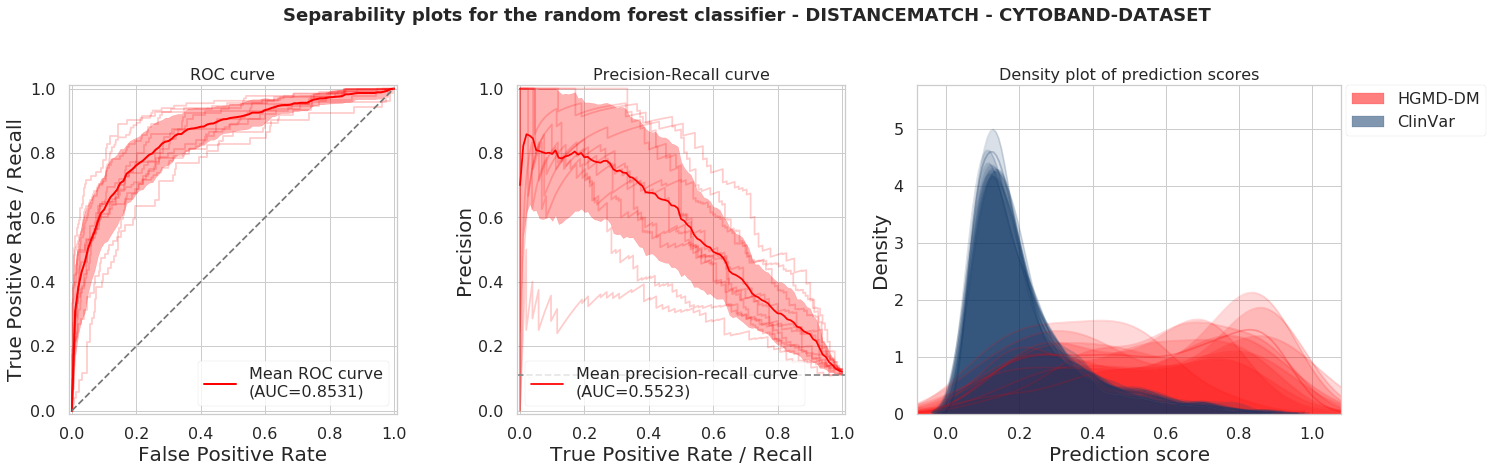

In [56]:
ML_visualization.separability_plots(
                    cross_dataset_kf_results_distmatch_onCytobandMatch,
                    mean_only=False,
                    class_names = ['ClinVar','HGMD-DM'],
                    color_positives=dataset_colors['HGMD-DM'],
                    color_negatives=dataset_colors['ClinVar_ctrl'],
                    color_surface=dataset_colors['HGMD-DM'],
                    main_title='Separability plots for the random forest classifier - DISTANCEMATCH - CYTOBAND-DATASET',
                    savefig_file="/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/cross-comparisons/HGMD-DM_DISTANCEMATCH_cross-validation-CYTOBANDMATCH.svg"
                    )